<a href="https://colab.research.google.com/github/lblogan14/bayes_methods_for_hackers/blob/main/ch2_more_on_pymc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 2. A Little More on PyMC

##Intro

* **Parent variables** are variables that influence another variable
* **Child variables** are variables that are affected by other variables -- that is, are the subject of parent variables

A variable can be both a parent and child. For example, 

In [ ]:
!pip install pymc

     |████████████████████████████████| 389kB 2.7MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp36-cp36m-linux_x86_64.whl size=1275929 sha256=46d07bd4d4f0ed4d422d45fbd00978e05643b9fd1b1df77eceeb81473419e151
  Stored in directory: /root/.cache/pip/wheels/0b/a8/e7/8f3ba91a39294d538a92db052fd1fcba1fca74a58c8b022026
Successfully built pymc


In [ ]:
import pymc as pm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
lambda_ = pm.Exponential('poisson_param', 1)
# used in the call the next variable
data_generator = pm.Poisson('data_generator', lambda_)

data_plus_one = data_generator + 1

In the code above, `lambda_` controls the parameter of `data_generator`, hence influences its values. `data_generator` is a parent to the variable `data_plus_one`.

A variable's children and parent variables can be accessed:

In [ ]:
print("Children of `lambda_`: ", lambda_.children)
print("Parents of `data_generator`: ", data_generator.parents)
print("Children of `data_generator`: ", data_generator.children)

Children of `lambda_`:  {<pymc.distributions.new_dist_class.<locals>.new_class 'data_generator' at 0x7f883fd690f0>}
Parents of `data_generator`:  {'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'poisson_param' at 0x7f883fd690b8>}
Children of `data_generator`:  {<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x7f885f7fe358>}


###PyMC Variables
The PyMC variables has a `value` property, which may change given the variable's parents' values.

In [ ]:
print('lambda_.value =', lambda_.value)
print('data_generator.value =', data_generator.value)
print('data_plus_one.value =', data_plus_one.value)

lambda_.value = 0.319946212016034
data_generator.value = 0
data_plus_one.value = 1


PyMC is concerned with two types of programming variables:
* **Stochastic variables** - values are still random even if all the values of the variables' parents are known
* **Deterministic varaibles** - values are not random if the variables' parents are known

To initialize stochastic variables:

In [ ]:
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)
some_variable.value

array(1)

For multivariable problems, set the `size` keyword in the call to a `Stochastic` variable to create an array of (independent) stocahstic variables.

In [ ]:
N = 10
betas = pm.Uniform('betas', 0, 1, size=N)
betas.value

array([0.63481084, 0.65946323, 0.82053905, 0.60464278, 0.49171533,
       0.57995735, 0.04617103, 0.44825348, 0.71125004, 0.75522044])

The `random()` method generates a new random value

In [ ]:
lambda_1 = pm.Exponential('lambda_1', 1) # prior on first behavior
lambda_2 = pm.Exponential('lambda_2', 1) # prior on second behavior
tau = pm.DiscreteUniform('tau', lower=0, upper=10) # prior on behavior change

print('Initialized values...')
print('lambda_1.value: {:.3f}'.format(lambda_1.value))
print('lambda_2.value: {:.3f}'.format(lambda_2.value))
print('tau.value: {:.3f}'.format(tau.value))
print()

lambda_1.random(), lambda_2.random(), tau.random()

print('After calling random() on the variables...')
print('lambda_1.value: {:.3f}'.format(lambda_1.value))
print('lambda_2.value: {:.3f}'.format(lambda_2.value))
print('tau.value: {:.3f}'.format(tau.value))

Initialized values...
lambda_1.value: 0.736
lambda_2.value: 1.781
tau.value: 1.000

After calling random() on the variables...
lambda_1.value: 0.321
lambda_2.value: 3.949
tau.value: 1.000


Most variables modeling here are stochastic. The deterministic variables are intiaited with a `pymc.deterministic` wrapper - *decorators*

The declaration of a deterministic variable uses a Python function: (to use a *decorator*)

In [ ]:
@pm.deterministic
def some_deterministic_var(v1=v1, ):
    #....

Another way to create deterministic variables is to use elementay operations:

In [ ]:
type(lambda_1 + lambda_2), type(lambda_1)

(pymc.PyMCObjects.Deterministic,
 pymc.distributions.new_dist_class.<locals>.new_class)

The model in Chapter 1:
$$\lambda = \begin{cases}
\lambda_1 & \text{if }t<\tau\\
\lambda_2 & \text{if }t\geq \tau\end{cases}$$
can be written in PyMC code:

In [ ]:
import numpy as np
n_data_points = 5

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

###Including Observations in the Model

In [ ]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

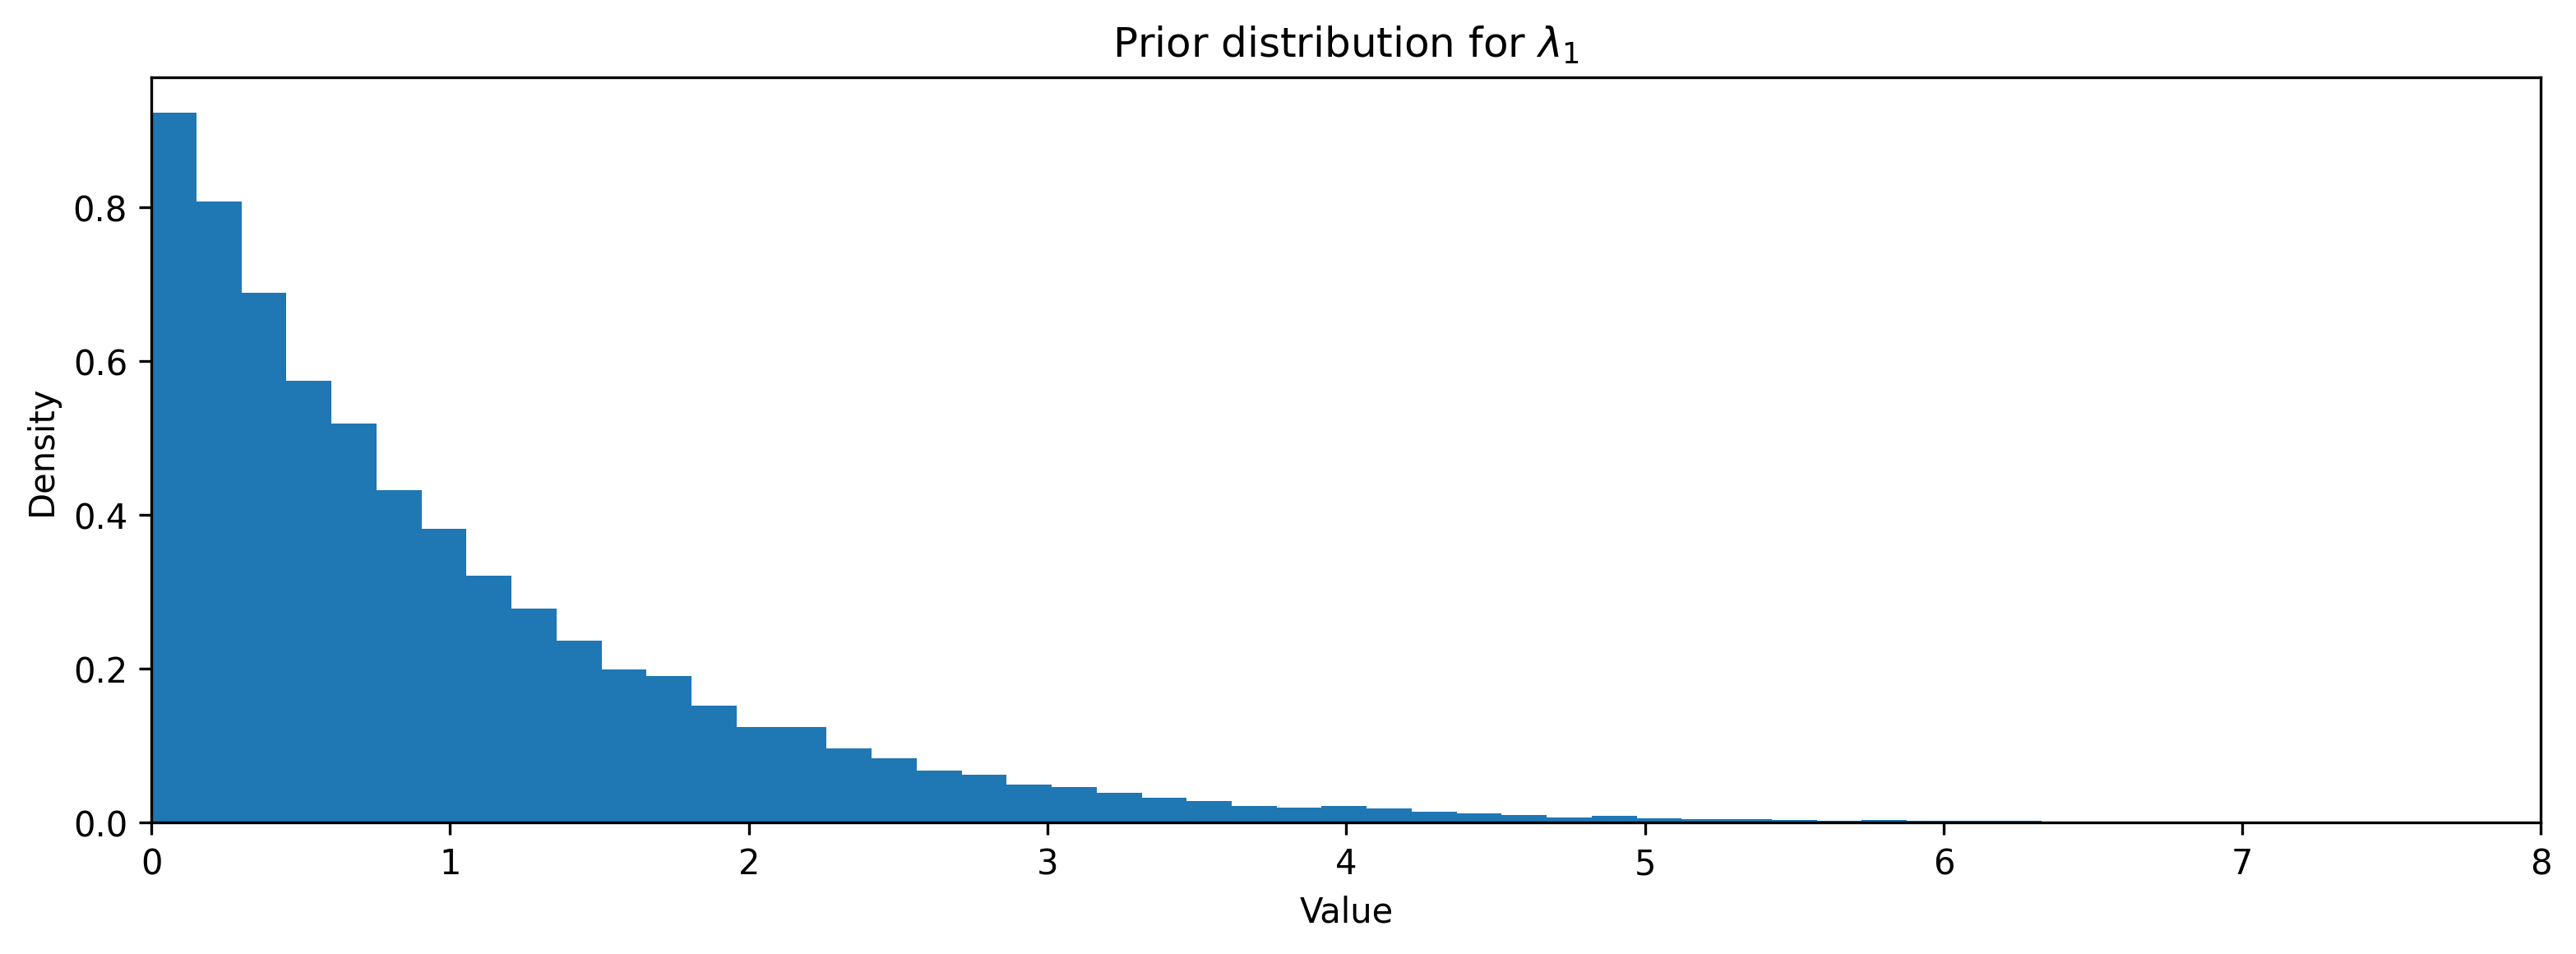

In [ ]:
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, density=True, histtype='stepfilled')
plt.title('Prior distribution for $\lambda_1$')
plt.xlabel('Value')
plt.ylabel('Density')
plt.xlim(0,8);

The prior distribution is denoted as $P(A)$.

The keyword `observed` in the PyMC stocahstic variables fixes the variable's current value if setting to `True`. Need to specify an initial `value` in the variable's creation:

In [ ]:
data = np.array([10, 5])
fixed_variable = pm.Poisson('fxd', 1, value=data, observed=True)
print('value: ', fixed_variable.value)
print('calling .random()')
fixed_variable.random()
print('value: ', fixed_variable.value)

value:  [10  5]
calling .random()
value:  [10  5]


This used to include data into the model: initializing a stochastic variable to have a *fixed value*.

Finally, all the created variables are wrapped into a `pm.Model` class.

In [ ]:
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])

##Modeling Approaches
A good starting thought to Bayesian modeling to think about *how the data might have been generated*.

###Same Story, Different Ending
In the following, a possible realization of the dataset can be simulated.

In [ ]:
# 1. specify when the user's behavior switches by sampling from DiscreteUniform(0,80)
tau = pm.rdiscrete_uniform(0, 80)
print(tau)

10


In [ ]:
# 2. Draw lambda_1, lambda_2 from an Exponential
alpha = 1./20
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print(lambda_1, lambda_2)

9.70626189603332 24.24902023911473


In [ ]:
# 3. for days < tau, lambda=lambda_1; for days >= tau, lambda=lambda_2
lambda_ = np.r_[lambda_1*np.ones(tau), lambda_2*np.ones(80-tau)]
print(lambda_)

[ 9.7062619   9.7062619   9.7062619   9.7062619   9.7062619   9.7062619
  9.7062619   9.7062619   9.7062619   9.7062619  24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024 24.24902024
 24.24902024 24.24902024]


In [ ]:
# 4. Sample from Poisson
data = pm.rpoisson(lambda_)
print(data)

[16 12 10 12 15  6 11  5 11  7 17 23 28 23 19 28 24 19 20 23 17 27 24 22
 27 14 12 22 31 35 22 21 23 28 26 20 30 26 27 20 18 29 23 22 26 26 24 22
 25 35 18 20 19 22 28 21 25 27 28 38 19 22 18 25 23 30 21 27 21 18 16 14
 18 20 21 22 27 18 28 27]


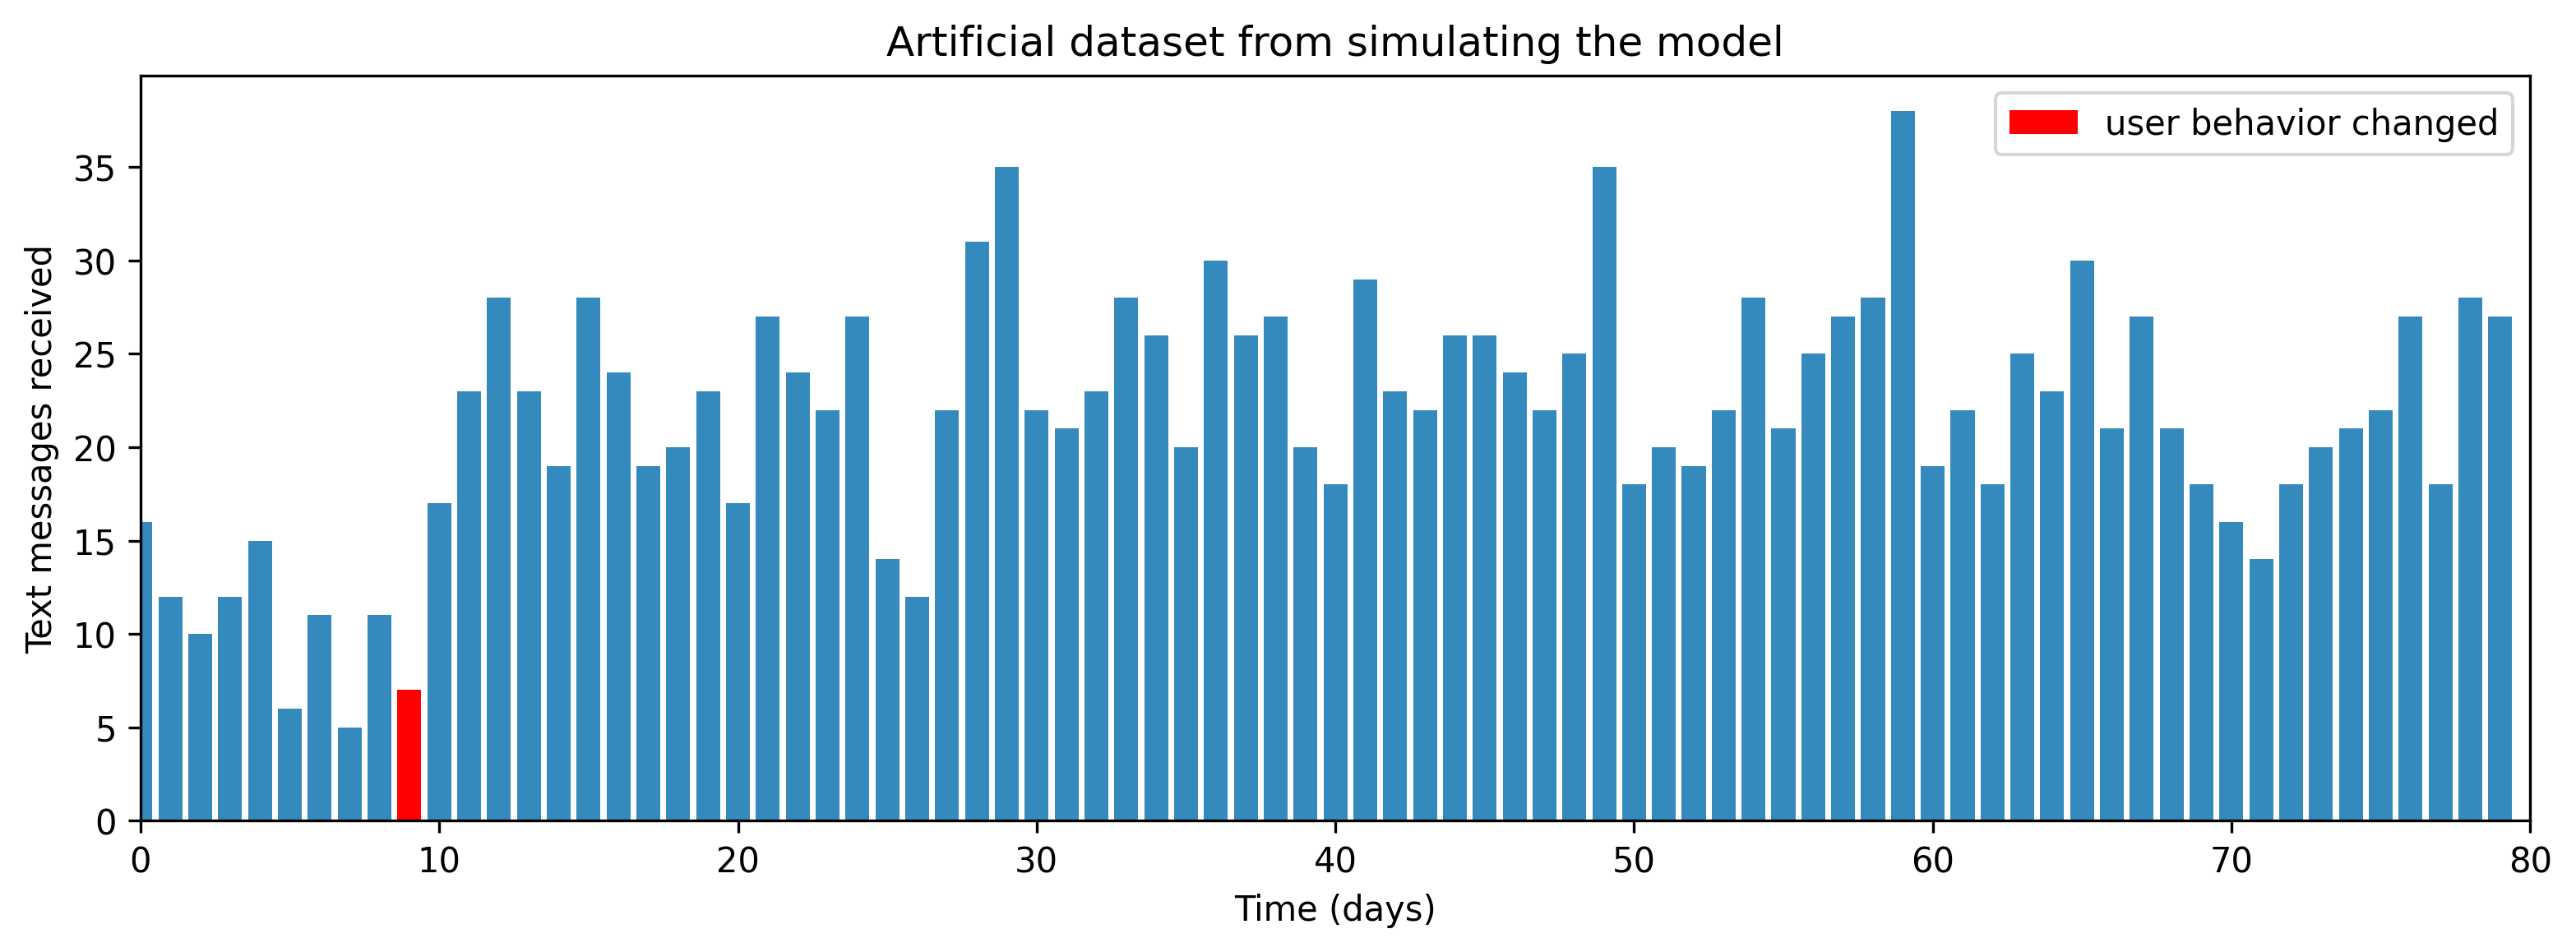

In [ ]:
# 5. plot the artificial dataset
plt.bar(np.arange(80), data, color='#348ABD')
plt.bar(tau-1, data[tau-1], color='r', label='user behavior changed')
plt.xlabel('Time (days)')
plt.ylabel('Text messages received')
plt.title('Artificial dataset from simulating the model')
plt.xlim(0, 80)
plt.legend();

The ability to generate an artificial dataset can be used for Bayesian inference:

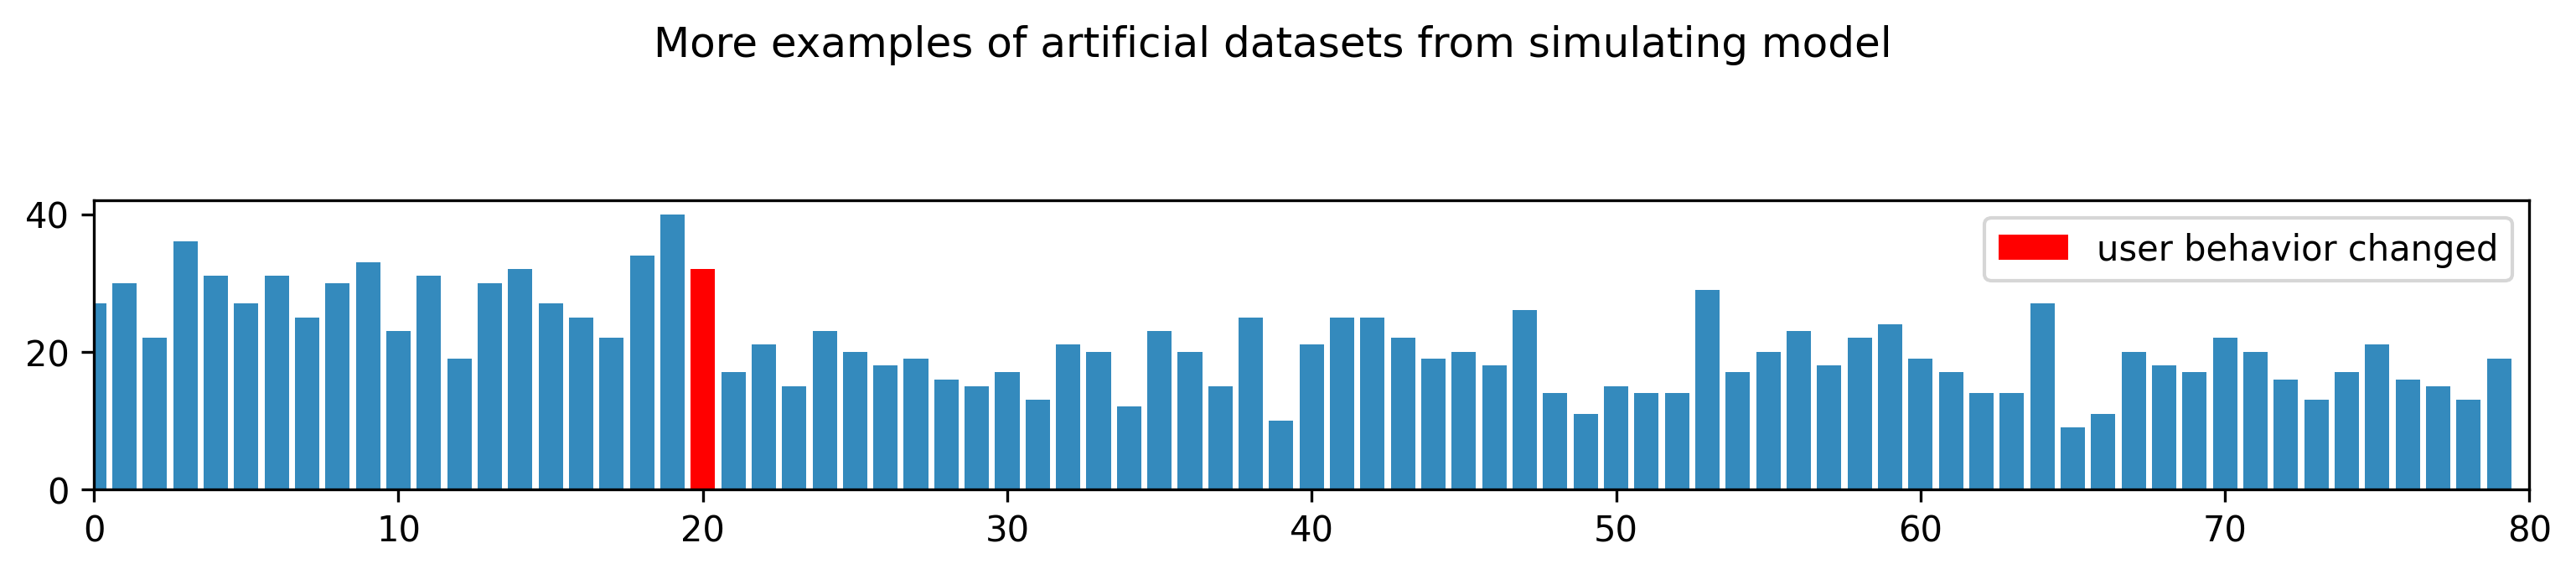

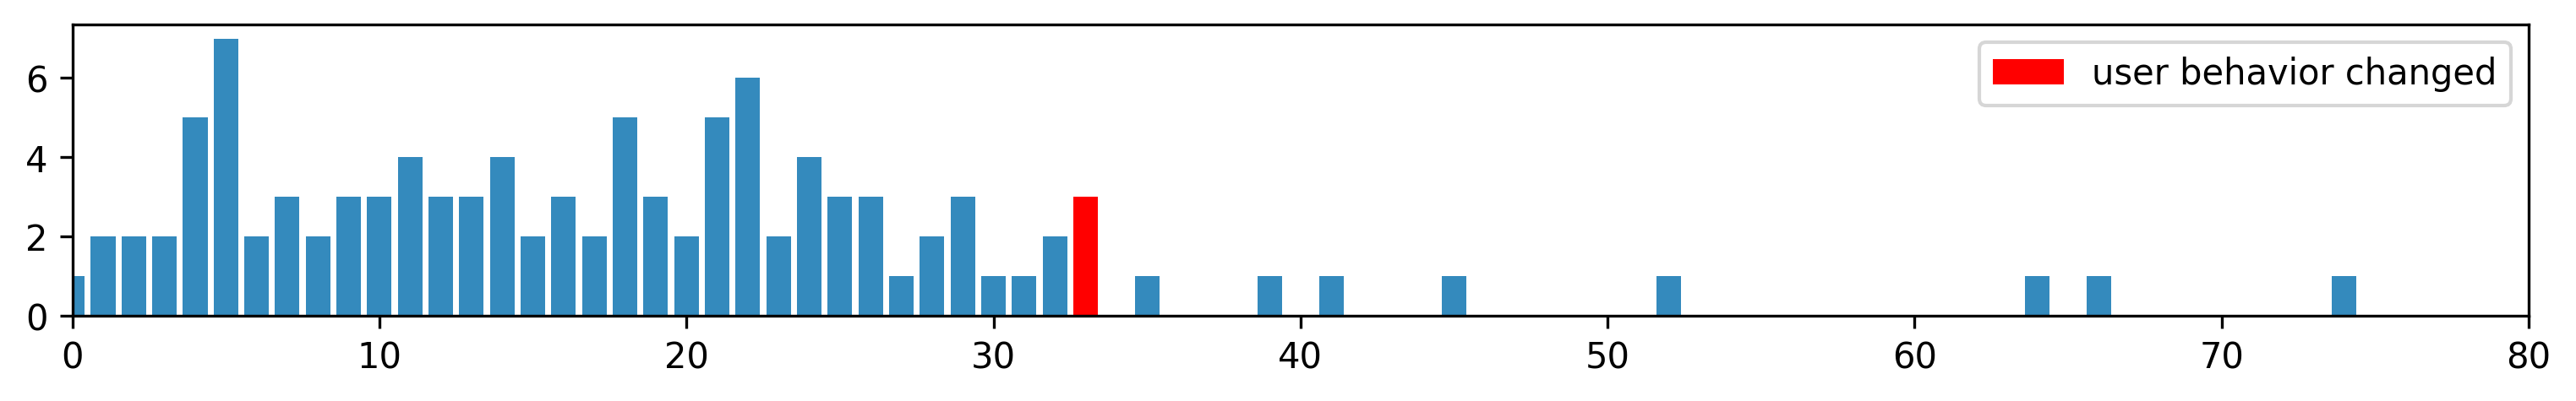

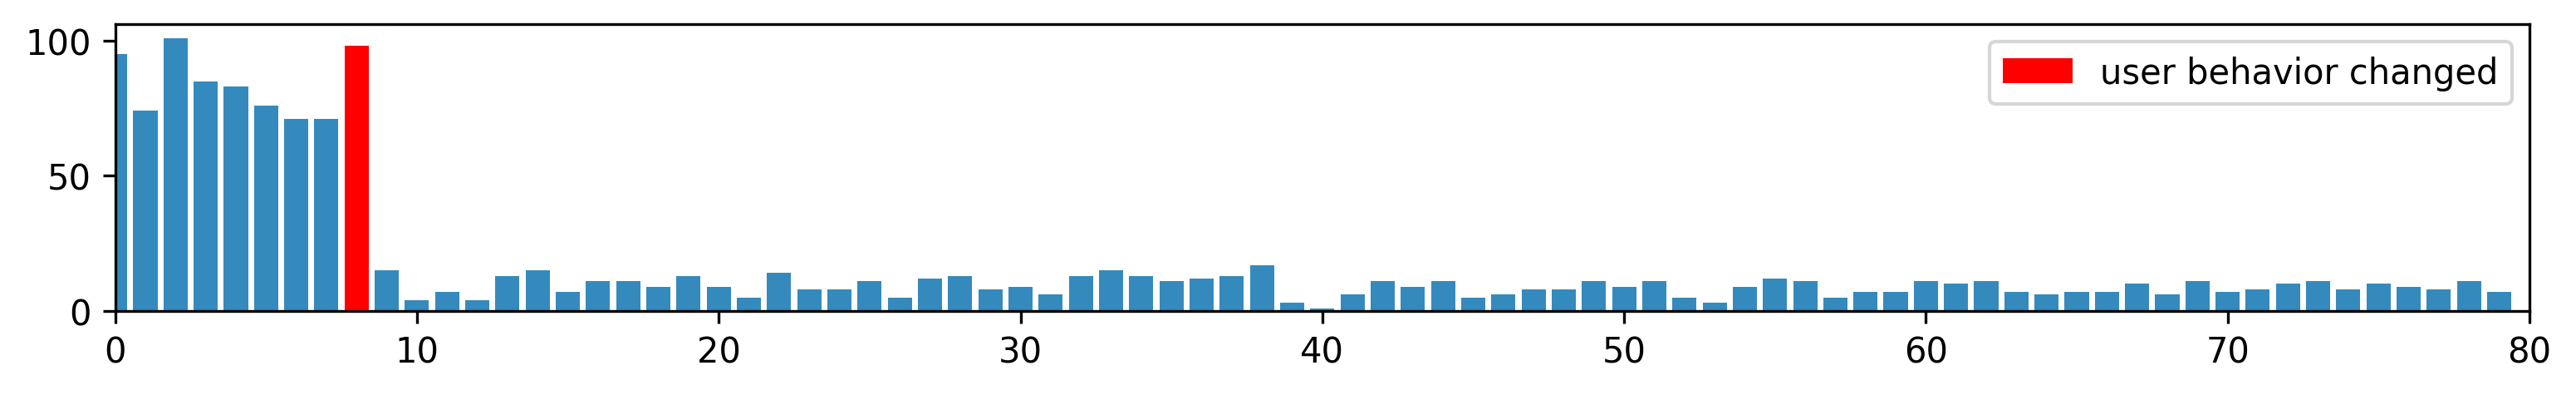

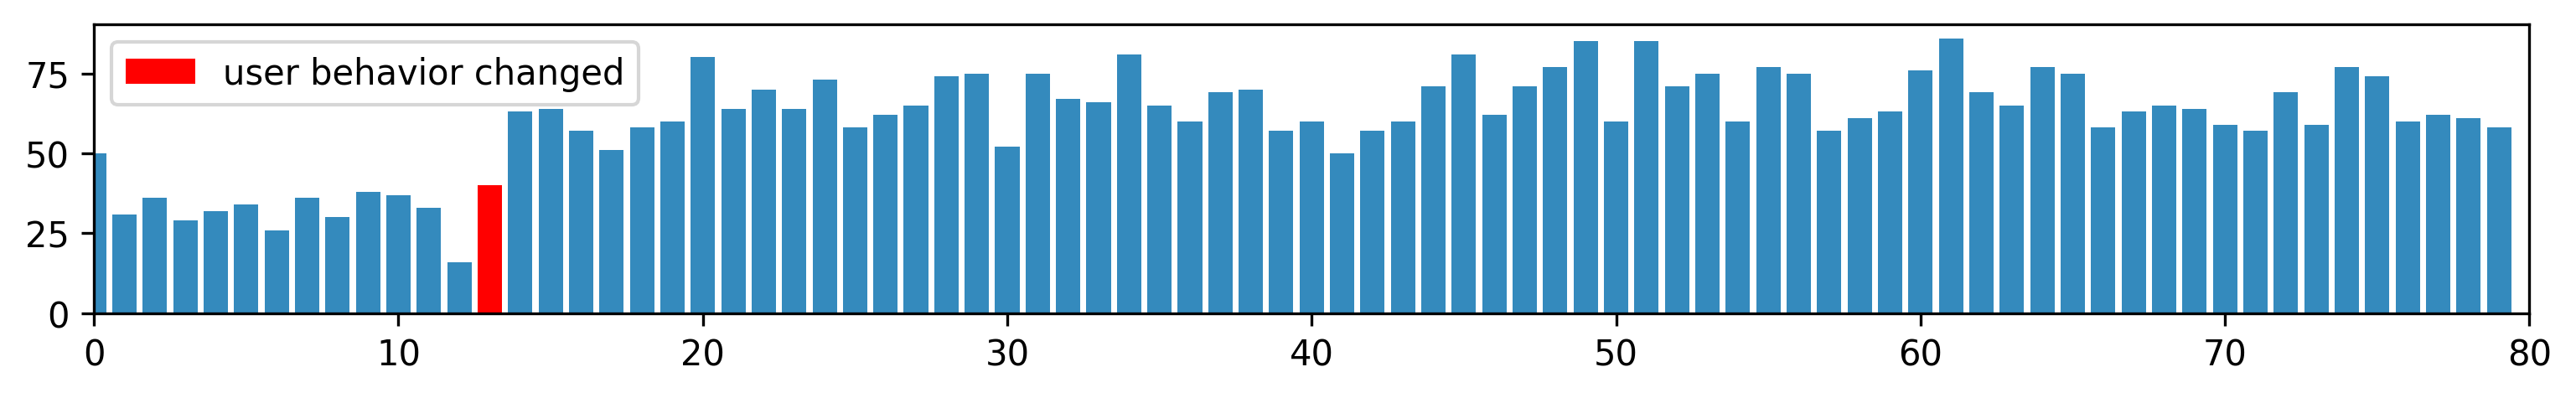

In [ ]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1/20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80-tau)]
    plt.bar(np.arange(80), data, color='#348ABD')
    plt.bar(tau-1, data[tau-1], color='r', label='user behavior changed')
    #plt.xlabel('Time (days)')
    #plt.ylabel('Text messages received')
    plt.xlim(0, 80)
    plt.legend()
    plt.show()

figsize(12.5, 7)
plt.suptitle('More examples of artificial datasets from simulating model')
for i in range(1,5):
    plt.subplot(4, 1, i)
    plot_artificial_sms_dataset()

###Example: Bayesian A/B Testing
A/B testing is a statistical pattern for determining the difference of effectiveness between two different treatments.

Assume there is some probability $p_A$ that users who are shown site $A$ eventually convert, which is the true effectiveness of site $A$ but is unknown for now.

Suppose site $A$ was shown to $N$ people, and $n$ people converted. The *observed frequency* $\frac{n}{N}$ does not necessarily equal $p_A$. 

Noise and complexities hide the true frequency and it must be *inferred* from observed data.

To set up a Bayesian model, need to assign prior distributions to the unknown quantities. Assume $p_A$ is uniform over [0,1]$:

In [ ]:
import pymc as pm

# The parameters are the bounds of the Uniform
p = pm.Uniform('p', lower=0, upper=1)

Suppose $p_A$=0.05 and $N$=1500 users shown site $A$, simulate whether the user made a purchase or not. To simulate this from $N$ trials, use a **Bernoulli distribution**. If $X\sim\text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1-p$.

In [ ]:
# set constants
p_true = 0.05 # this is unknown in real-life
N = 1500

# Sample N Bernoulli random variables from Ber(0.05).
# Each random variable as a 0.05 chance of being a 1.
# This is the data-generation step.
occurrences = pm.rbernoulli(p_true, N)

print(occurrences) # True==1, False==0
print(occurrences.sum())

[False False False ... False False False]
75


The observed frequency is:

In [ ]:
# occurrences.mean() is equal to n/N
print('What is the observed frequency in Group A? {:.4f}'.format(occurrences.mean()))
print('Does the obvserved frequency equal to the true frequency? {}'.format(occurrences.mean() == p_true))

What is the observed frequency in Group A? 0.0500
Does the obvserved frequency equal to the true frequency? True


Combine the observations into the PyMC `observed` variable, and run the inference algorithm:

In [ ]:
# Include the observations, which are Bernoulli
obs = pm.Bernoulli('obs', p, value=occurrences, observed=True)

mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.4 sec

The posterior distribution of the unknown $p_A$:

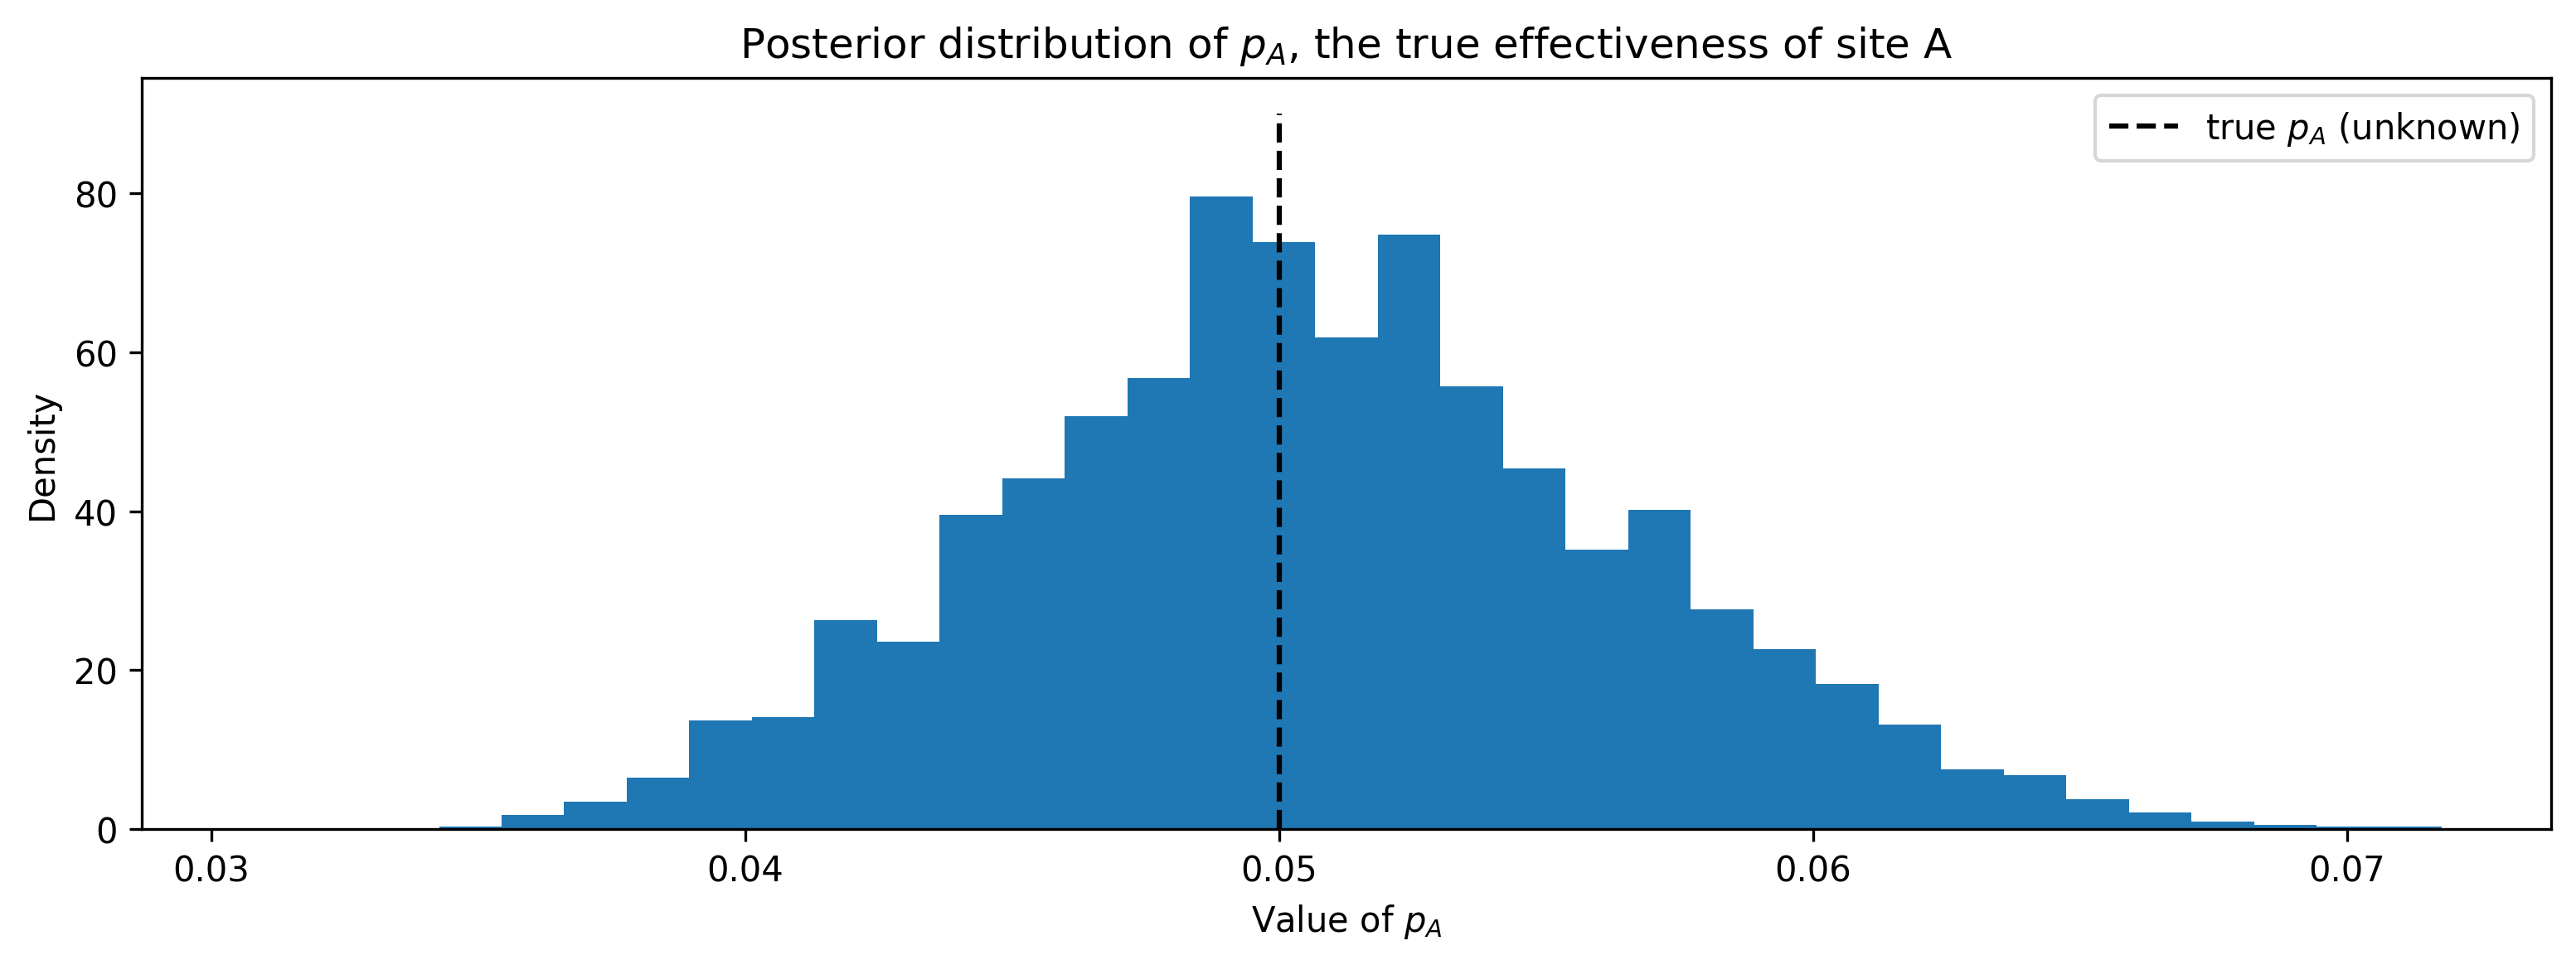

In [ ]:
figsize(12.5, 4)
plt.title('Posterior distribution of $p_A$, the true effectiveness of site A')
plt.vlines(p_true, 0, 90, linestyles='--', label='true $p_A$ (unknown)')
plt.hist(mcmc.trace('p')[:], bins=35, histtype='stepfilled', density=True)
plt.xlabel('Value of $p_A$')
plt.ylabel('Density')
plt.legend();

A similar analysis can be done for site $B$'s response data. Assume that $p_B=0.04$ and delta=$p_A-p_B$=0.01, and $N_B$=750

In [ ]:
# both are unknown
true_p_A = 0.05
true_p_B = 0.04

# sample sizes are not the same
N_A = 1500
N_B = 750

# Generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print('Obs from Site A: ', observations_A[:30].astype(int), '...')
print('Obs from Site B: ', observations_B[:30].astype(int), '...')
print()
print(observations_A.mean())
print(observations_B.mean())

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...

0.058
0.030666666666666665


In [ ]:
# Set up the PyMC model, Assume Uniform priors for p_A and p_B
p_A = pm.Uniform('p_A', 0, 1)
p_B = pm.Uniform('p_B', 0, 1)

# Define the deterministic delta function. This is the unknown of interest
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

In [ ]:
# Set up observations
obs_A = pm.Bernoulli('obs_A', p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli('obs_B', p_B, value=observations_B, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 2.8 sec

The posterior distributions for the three unknowns:

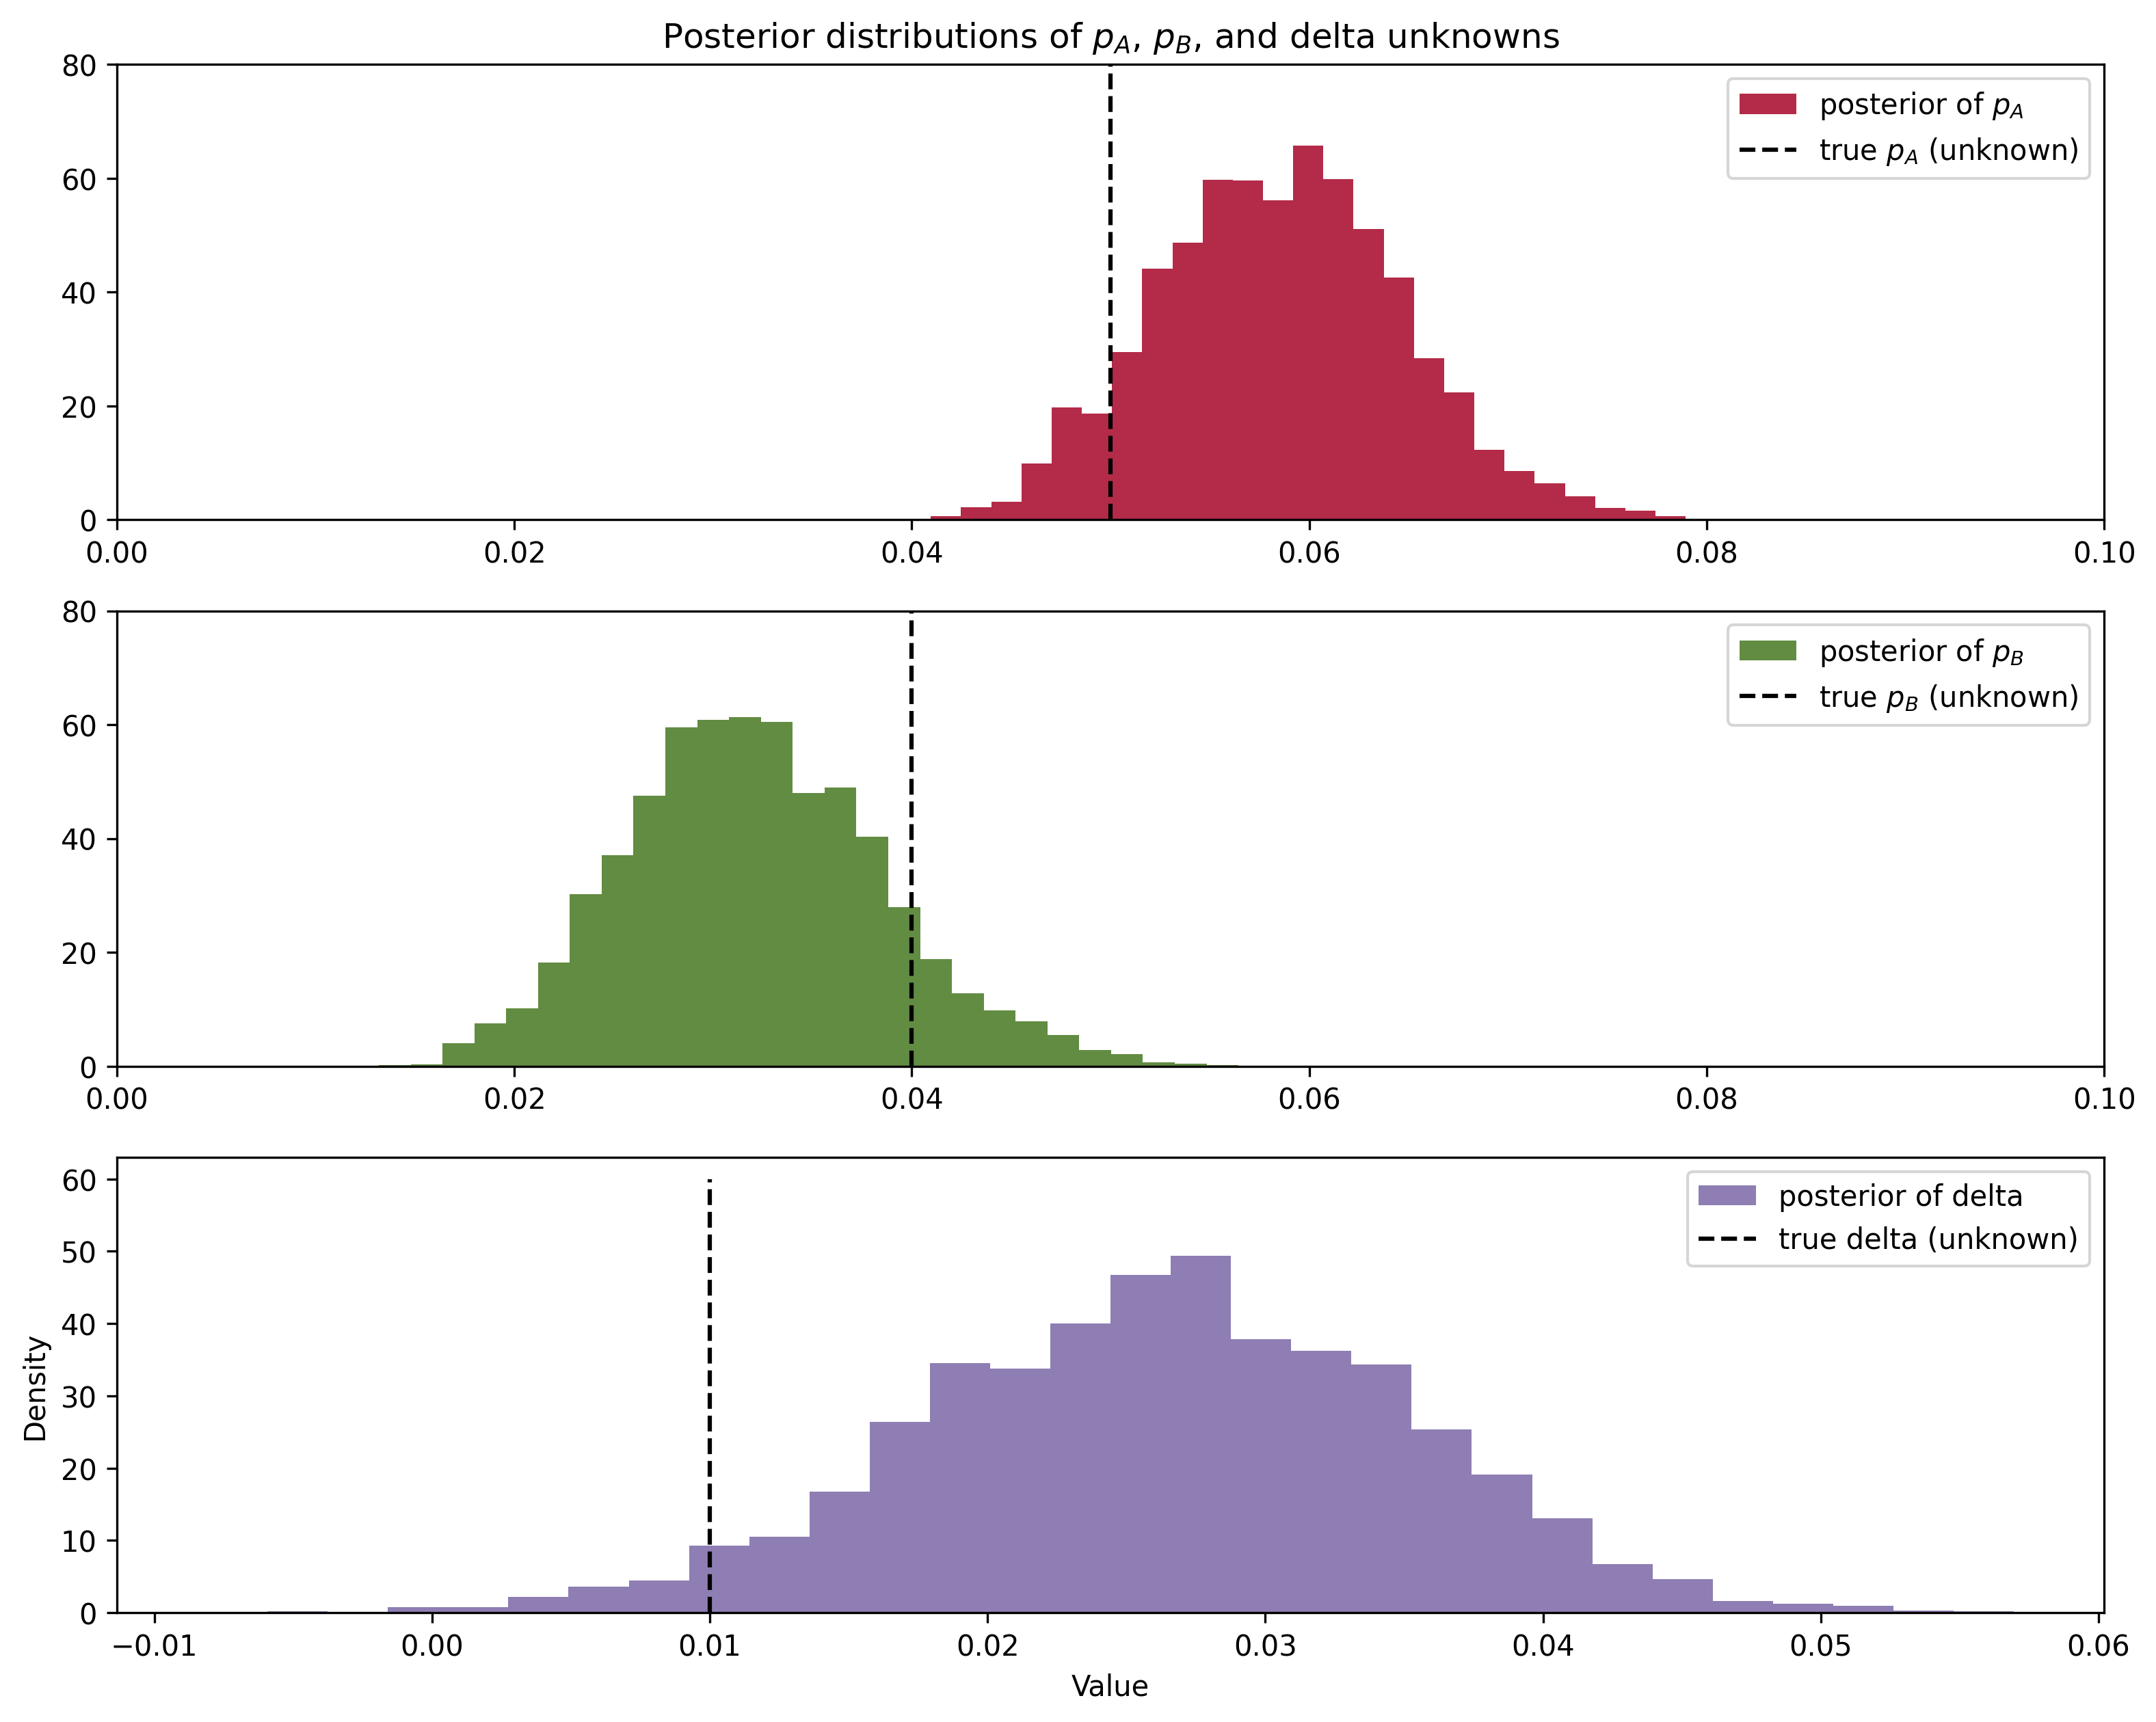

In [ ]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

figsize(12.5, 10)

# histograms of posteriors
ax = plt.subplot(311)
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label='posterior of $p_A$', color='#A60628', density=True)
plt.vlines(true_p_A, 0, 80, linestyles='--', label='true $p_A$ (unknown)')
plt.legend(loc='upper right')
plt.title('Posterior distributions of $p_A$, $p_B$, and delta unknowns')
plt.ylim(0, 80)

ax = plt.subplot(312)
plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label='posterior of $p_B$', color='#467821', density=True)
plt.vlines(true_p_B, 0, 80, linestyles='--', label='true $p_B$ (unknown)')
plt.legend(loc='upper right')
plt.ylim(0, 80)

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label='posterior of delta', color='#7A68A6', density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyles='--', label='true delta (unknown)')
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Density');

Note that $N_B < N_A$ makes the posterior distribution of $p_B$ less certain.

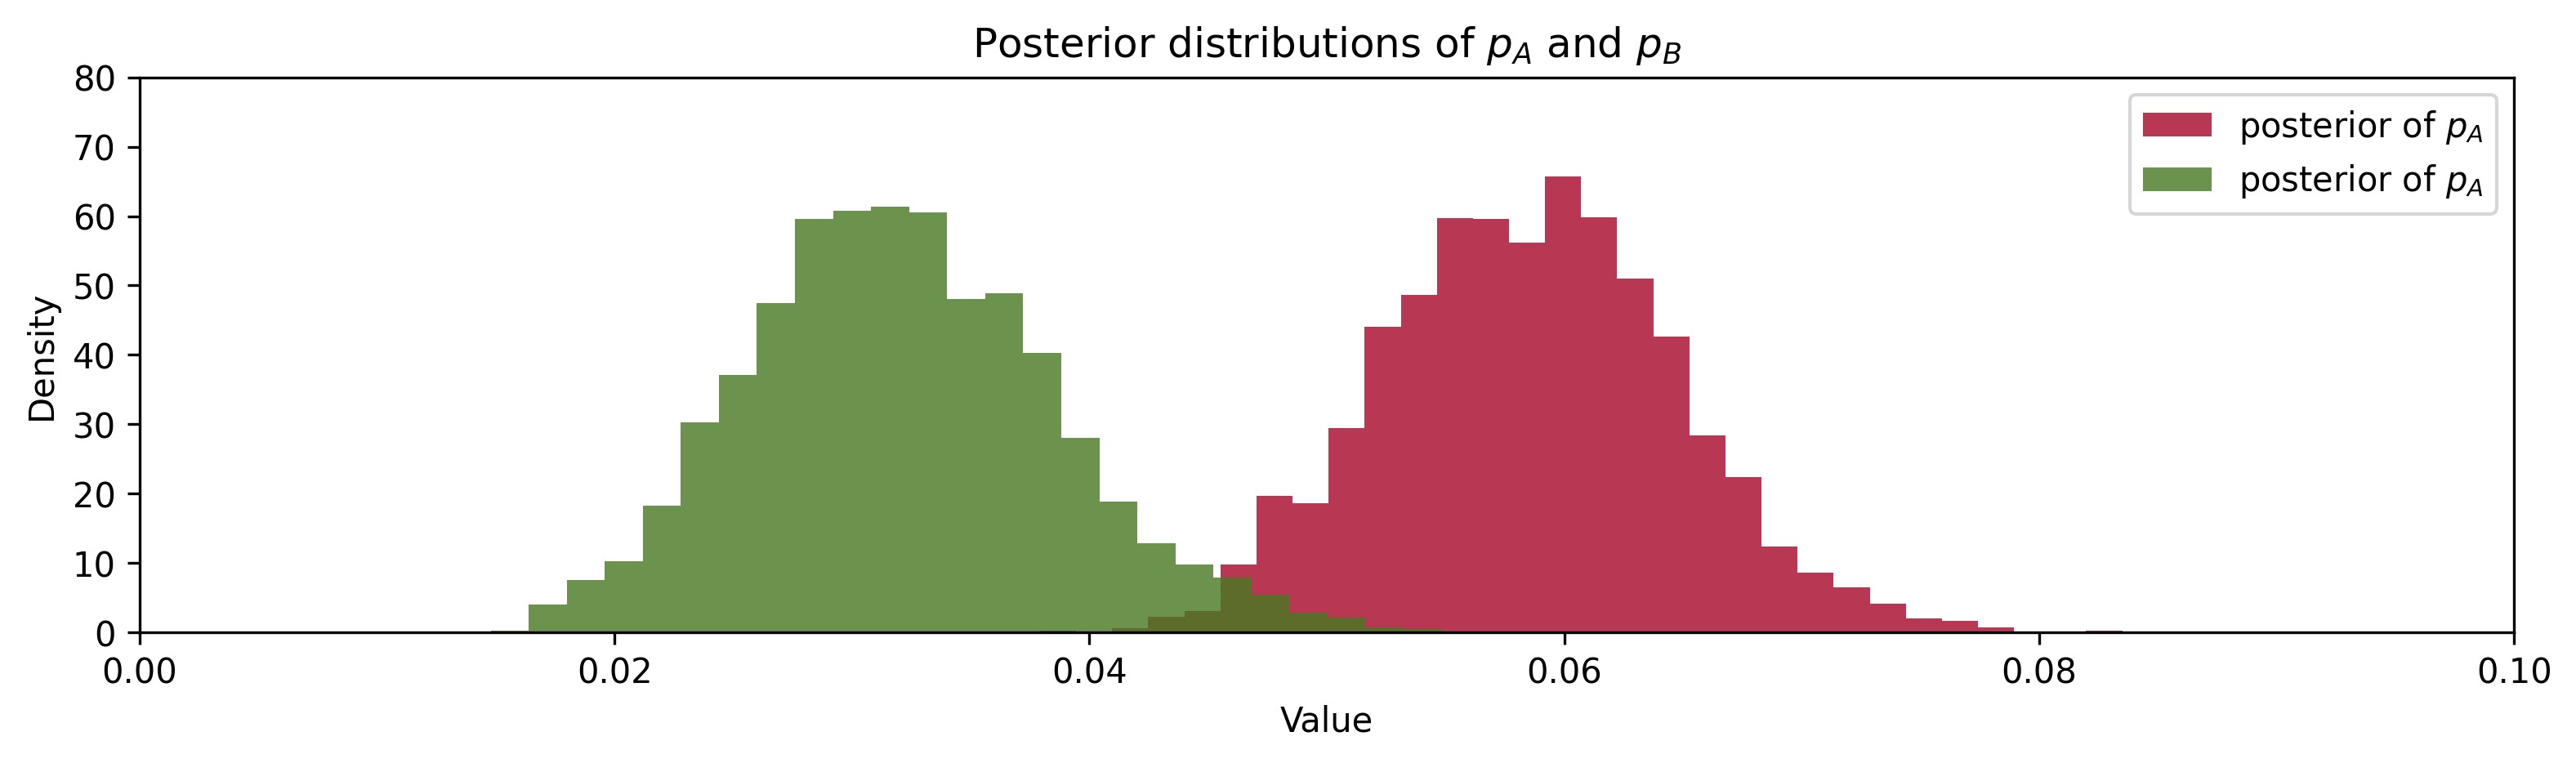

In [ ]:
figsize(12.5, 3)
# histogram of posteriors
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.8,
         label='posterior of $p_A$', color='#A60628', density=True)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.8,
         label='posterior of $p_A$', color='#467821', density=True)
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior distributions of $p_A$ and $p_B$')
plt.ylim(0, 80);

The probability of this inference can be computed:

In [ ]:
# Count the number of samples less than 0, i.e., the area under the curve
# before 0, representing the probability that site A is worse than site B.
print('Probability site A is WORSE than site B: {:.3f}'.format((delta_samples<0).mean()))
print('Probability site A is BETTER than site B: {:.3f}'.format((delta_samples>0).mean()))

Probability site A is WORSE than site B: 0.002
Probability site A is BETTER than site B: 0.998


###Example: An Algorithm for Human Deceit
People are not always honest with responses, which adds further complication into inference.

The binomial distribution is one of the most popular distributions because of its simplicity and usefulness. The binomial distribution has two parameters: $N$, a positive integer representing the number of trials or number of instances of potential events, and $p$, the probability of an event occurring in a single trial. It is a discrete distribution and the probability mass function is
$$P(X=k)=\binom{N}{k}p^k (1-p)^{N-k}$$
where $X$ is the number of events that occurred in the $N$ trials $(0\leq X\leq N$).

The expected value of a binomial is equal to $Np$.

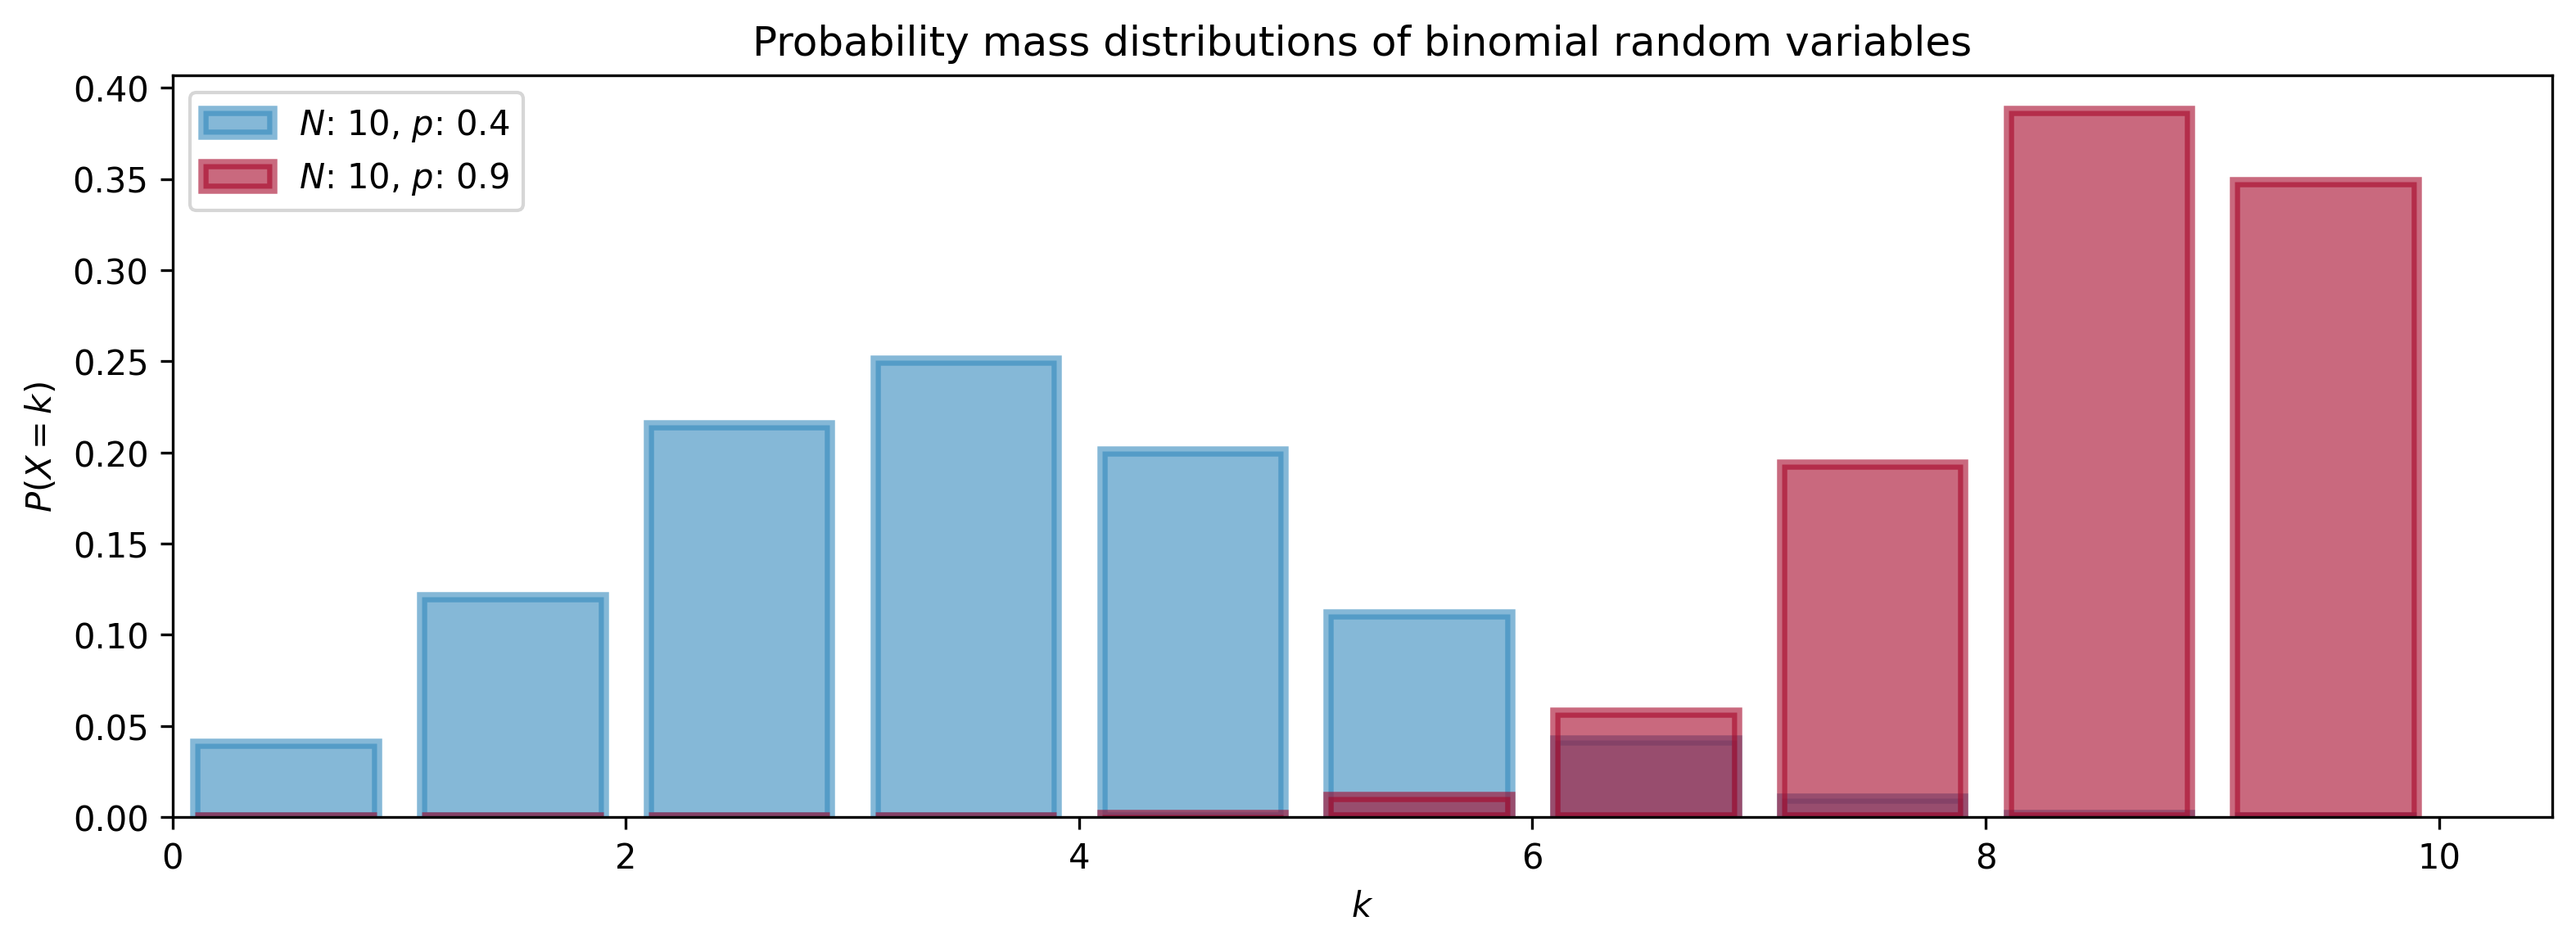

In [ ]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom
parameters = [(10, .4), (10, .9)]
colors = ['#348ABD', '#A60628']

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N+1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label='$N$: {:d}, $p$: {:.1f}'.format(N,p),
            linewidth=3)
plt.legend(loc='upper left')
plt.xlim(0, 10.5)
plt.xlabel('$k$')
plt.ylabel('$P(X=k)$')
plt.title('Probability mass distributions of binomial random variables');

###Example: Cheating among Students
Let $N$ be the total number of students who took the exam, and assuming each student is interviewed post-exam, an integer $X$ "Yes, I did cheat" is received. In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answer "Yes, I did cheat" if the coin flip lands heads, and $No, I did not cheat" if the coin flip lands tails

Suppose 100 students are being surveyed for cheating, and the proportion of cheaters $p$ is the objective. In the data-generation model, the true proportion of cheaters $p$ is sampled from a prior. Since there is nothing known about $p$, assume a Uniform(0,1) prior

In [ ]:
N = 100
p = pm.Uniform('freq_cheating', 0, 1)

The data-generation model assigns Bernoulli random variables to the 100 students: 1 implies a student cheated and 0 implies the student did not.

In [ ]:
true_answers = pm.Bernoulli('truths', p, size=N)

For the first coin flipped by each student, this can be modeled by sampling 100 Bernoulli random variables with $p=0.5$.



In [ ]:
first_coin_flips = pm.Bernoulli('first_flips', 0.5, size=N)
print(first_coin_flips.value)

[False  True  True False  True  True False  True  True  True False False
 False  True False False  True  True False False False False  True False
  True False False  True False  True  True  True False  True False False
 False  True  True False  True False False  True  True False  True False
  True  True False False  True False  True False  True  True False  True
 False False False  True  True  True  True False  True False False False
  True  True False False  True  True  True False False False  True False
  True False False  True False  True  True False  True False  True  True
 False False False False]


The possible realization of the second coin flips:

In [ ]:
second_coin_flips = pm.Bernoulli('second_flips', 0.5, size=N)

These two variables can be used to return a possible realization of the *observed proportion* of "Yes" responses using a PyMC `deterministic` variable:

In [ ]:
@pm.deterministic
def observed_proportion(t_a=true_answers,
                        fc=first_coin_flips,
                        sc=second_coin_flips):
    observed = fc * t_a + (1-fc) * sc
    return observed.sum() / float(N)

An element in the array `fc*t_a + (1-fc)*sc` is 1 *if and only if*
1. the first toss is heads and the student cheated or
2. the first toss is tails, and the second is heads, and otherwise is 0

If the researchers received 35 "Yes" responses, the researchers observe a binomial random variable with `N=100` and `p=observed_proportion` with `value=35`:

In [ ]:
X = 35

observations = pm.Binomial('obs', N, observed_proportion, observed=True, value=X)

Add all variables of interest to a `Model` container:

In [ ]:
model = pm.Model([p, true_answers, first_coin_flips,
                  second_coin_flips, observed_proportion, observations])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)

/usr/local/lib/python3.6/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 10.3 sec

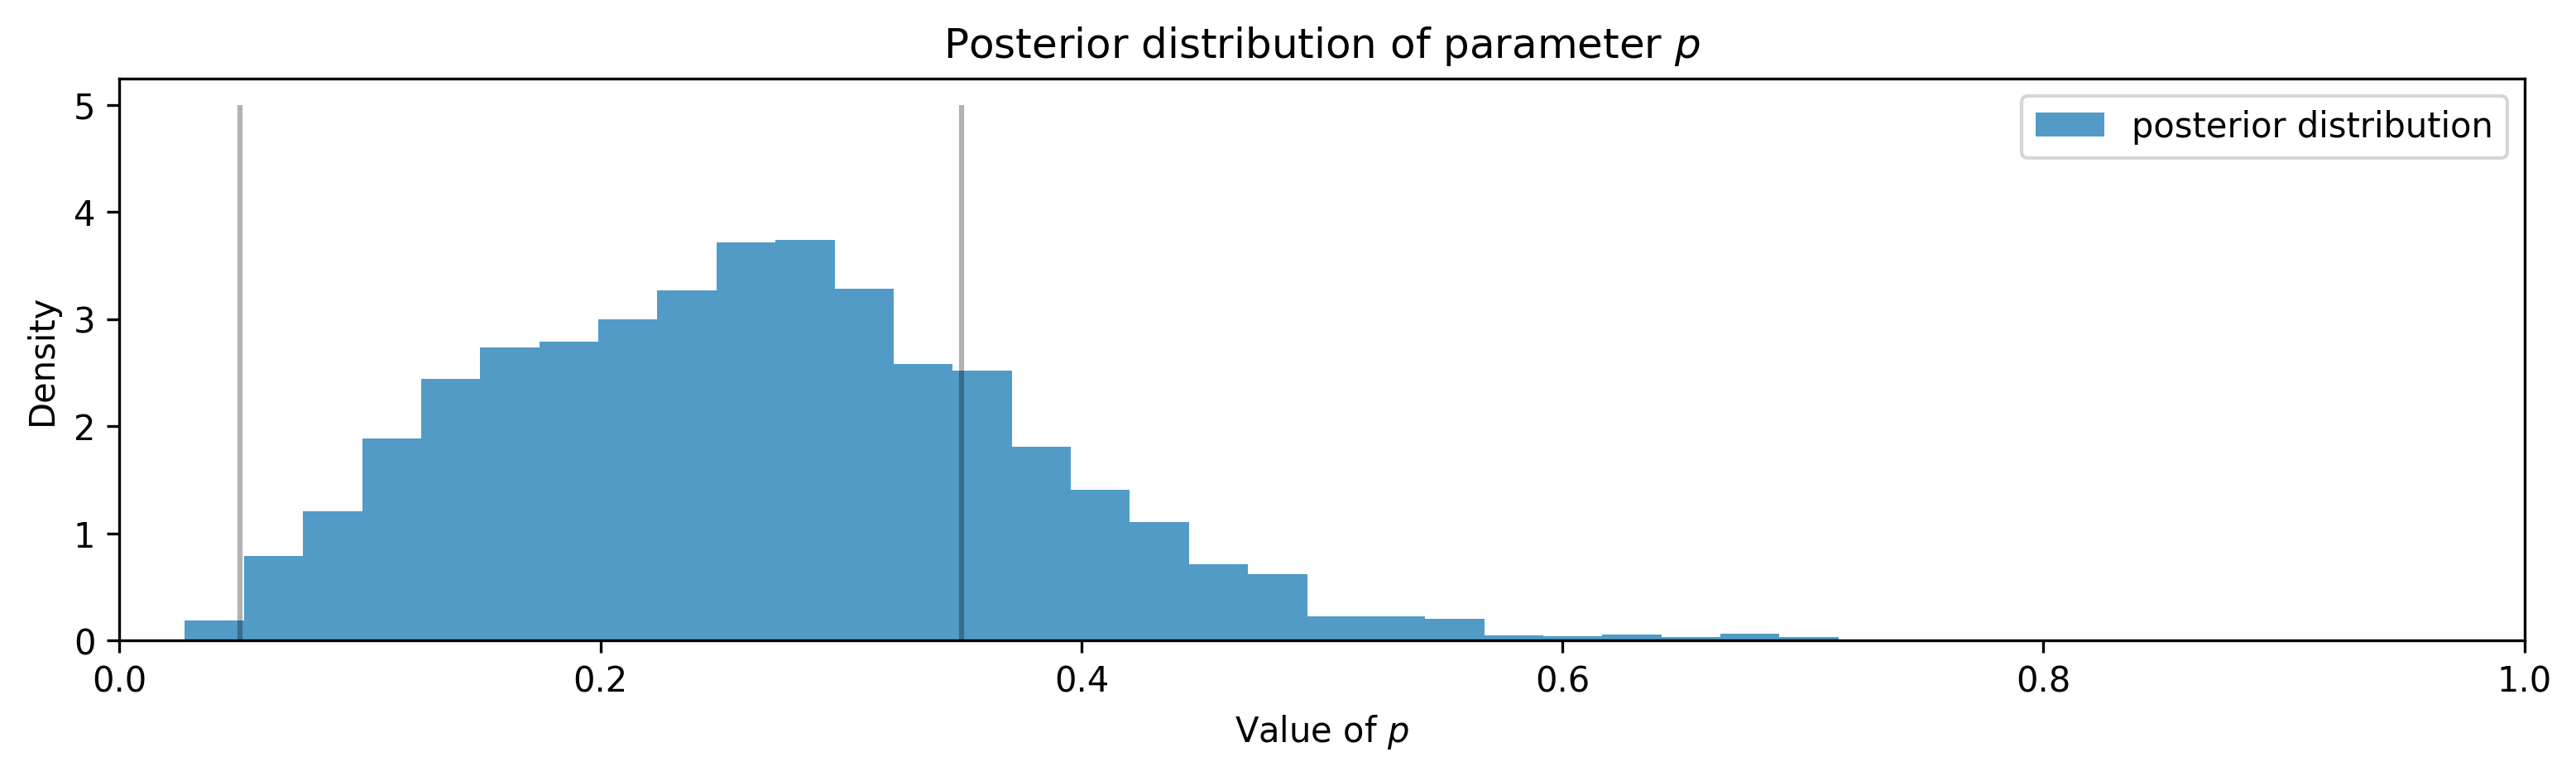

In [ ]:
figsize(12.5, 3)
p_trace = mcmc.trace('freq_cheating')[:]
plt.hist(p_trace, histtype='stepfilled', density=True,
         alpha=0.85, bins=30, label='posterior distribution',
         color='#348ABD')
plt.vlines([0.05, 0.35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.xlabel('Value of $p$')
plt.ylabel('Density')
plt.title('Posterior distribution of parameter $p$')
plt.legend();

Alternative approach is given a vlue for $p$, find the probability that the student will answer "Yes":
$$\begin{split}
P(\text{"Yes"})=& P(\text{heads on first coin})P(\text{cheater}) + P(\text{tails on first coin})P(\text{heads on second coin})\\
=& \frac{1}{2}p + \frac{1}{2}\frac{1}{2}\\
=& \frac{p}{2} + \frac{1}{4}
\end{split}
$$

Thus, knowing $p$ is the key here

In [ ]:
p = pm.Uniform('freq_cheating', 0, 1)

@pm.deterministic
def p_skewed(p=p):
    return 0.5*p + 0.25

This is the part to include the observed data (35 "Yes" responses):

In [ ]:
yes_responses = pm.Binomial('number_cheaters', 100, p_skewed,
                            value=35, observed=True)

Add all variables to `Model`

In [ ]:
model = pm.Model([yes_responses, p_skewed, p])

mcmc = pm.MCMC(model)
mcmc.sample(25000, 2500)

/usr/local/lib/python3.6/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 25000 of 25000 complete in 1.1 sec

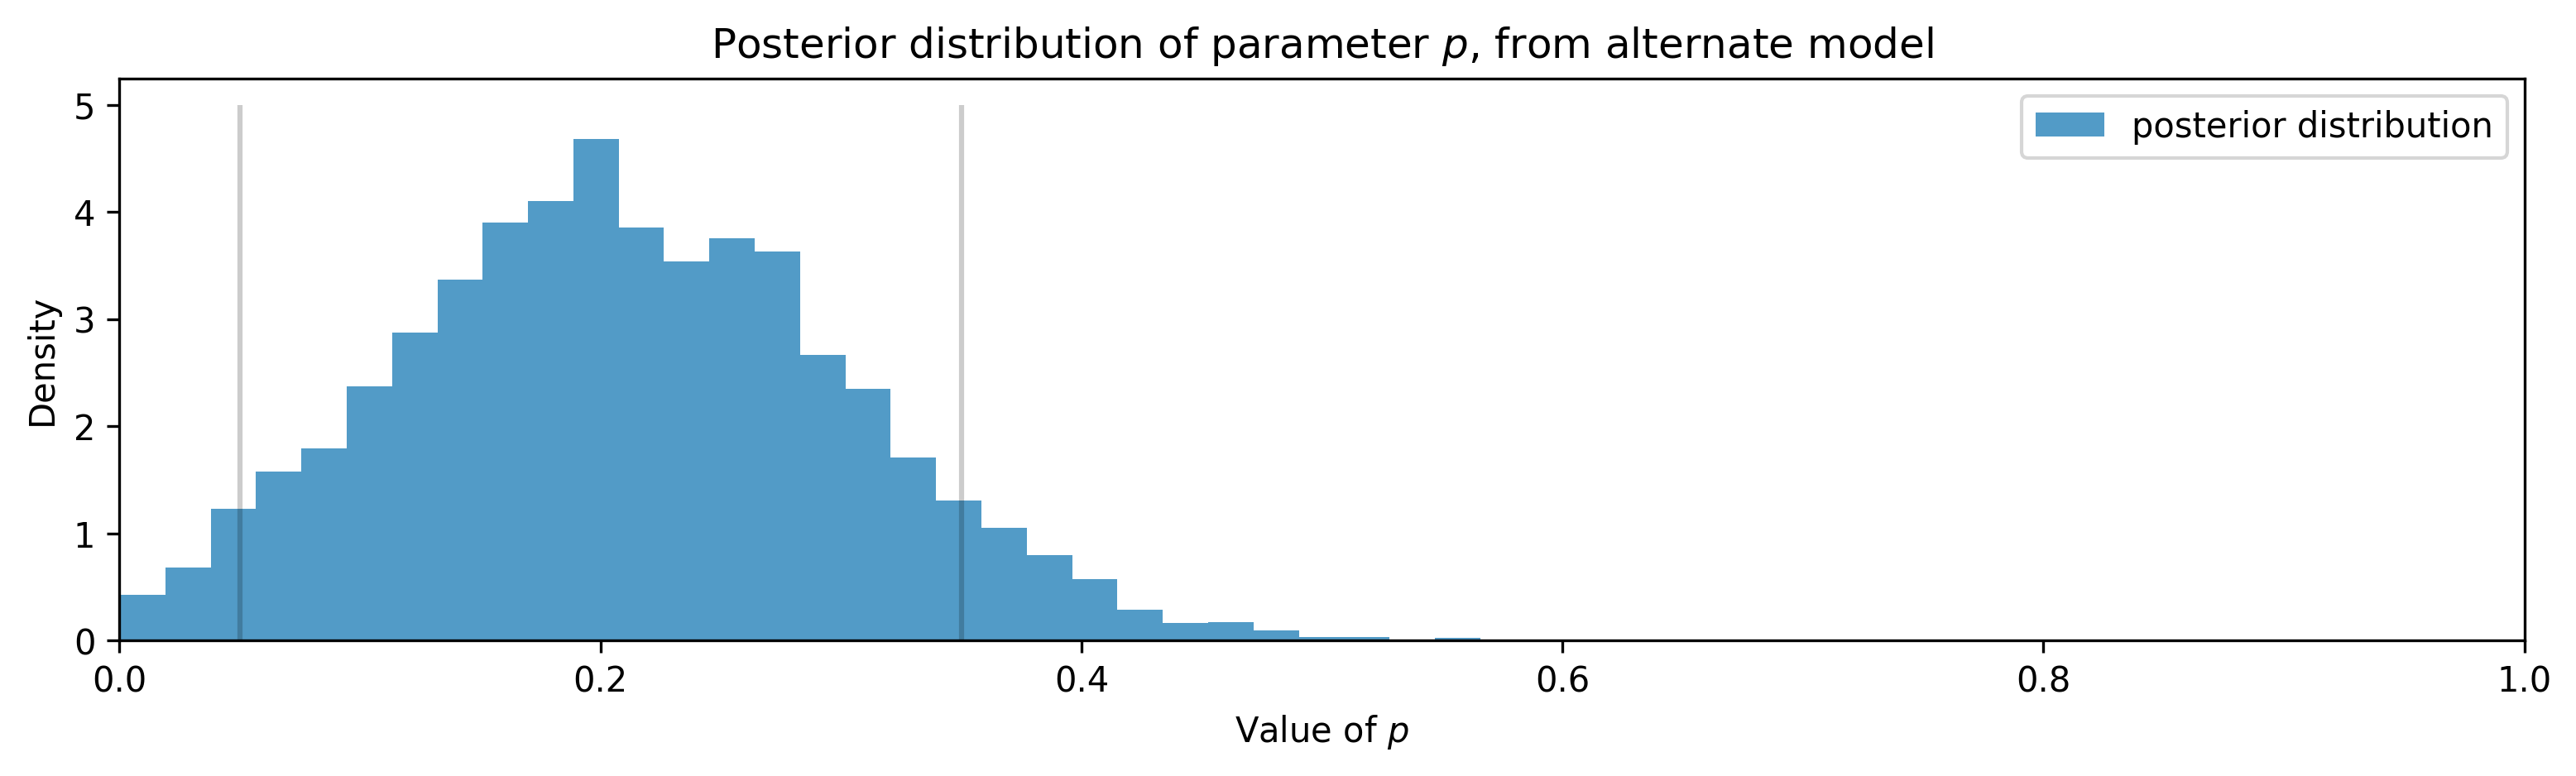

In [ ]:
figsize(12.5, 3)
p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", density=True,
         alpha=0.85, bins=30, label="posterior distribution",
         color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.xlabel("Value of $p$")
plt.ylabel("Density")
plt.title("Posterior distribution of parameter $p$, from alternate model")
plt.legend();

###Example: Challenger Space Shuttle Disaster

In [ ]:
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.array([
   # Date,Temperature,Damage Incident
['04/12/1981',66,0],
['11/12/1981',70,1],
['3/22/82',69,0],
#['6/27/82',80, np.nan],
['01/11/1982',68,0],
['04/04/1983',67,0],
['6/18/83',72,0],
['8/30/83',73,0],
['11/28/83',70,0],
['02/03/1984',57,1],
['04/06/1984',63,1],
['8/30/84',70,1],
['10/05/1984',78,0],
['11/08/1984',67,0],
['1/24/85',53,1],
['04/12/1985',67,0],
['4/29/85',75,0],
['6/17/85',70,0],
['7/29/85',81,0],
['8/27/85',76,0],
['10/03/1985',79,0],
['10/30/85',75,1],
['11/26/85',76,0],
['01/12/1986',58,1],
['1/28/86',31,'Challenger Accident']
])

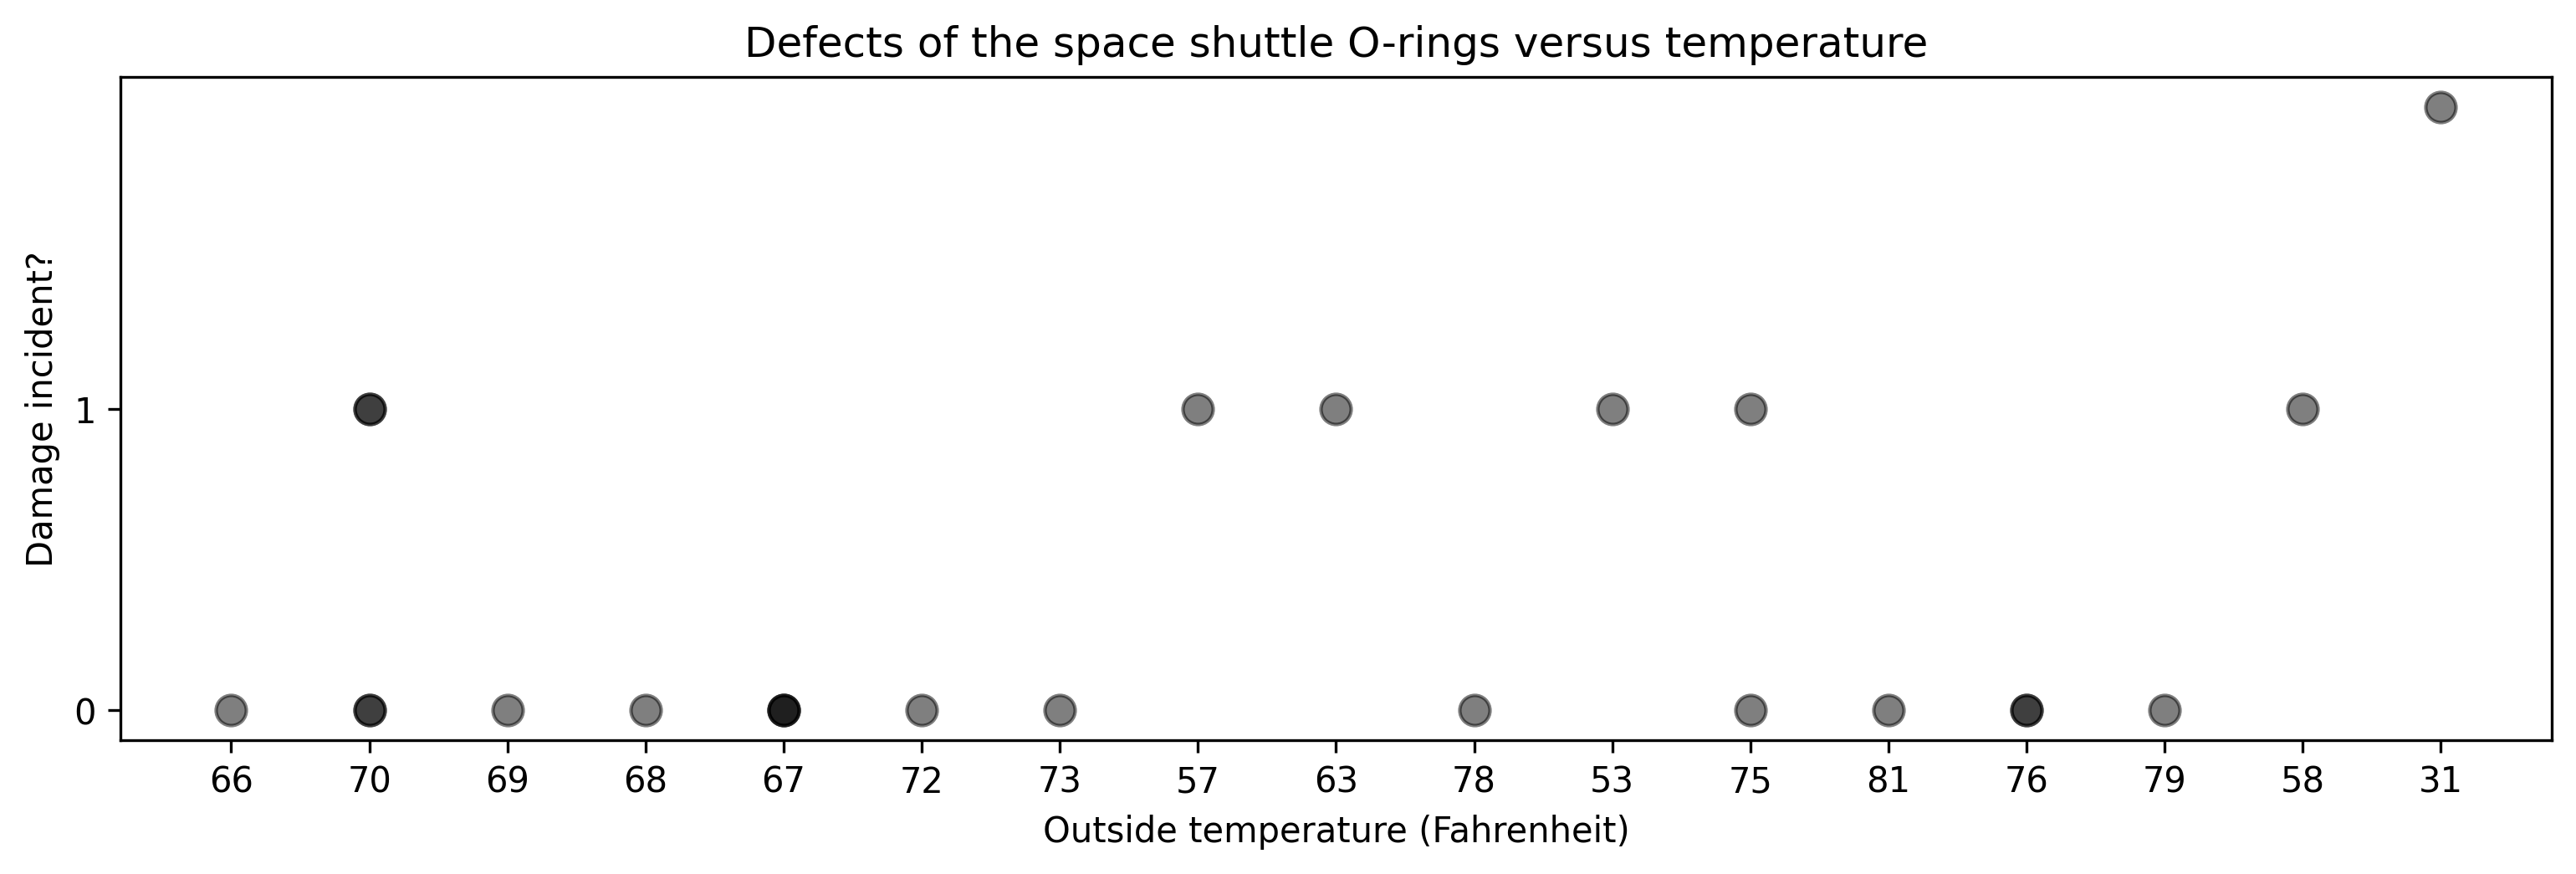

In [ ]:
figsize(12.5, 3.5)
plt.scatter(challenger_data[:,1], challenger_data[:,2], s=75,
            color='k', alpha=0.5)
plt.yticks([0,1])
plt.ylabel('Damage incident?')
plt.xlabel('Outside temperature (Fahrenheit)')
plt.title('Defects of the space shuttle O-rings versus temperature');

The probability of a damage incident here can be modeled as a *logistic function*:
$$p(t)=\frac{1}{1+e^{\beta t + \alpha}}$$

In [ ]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1. + np.exp(np.dot(beta, x) + alpha))

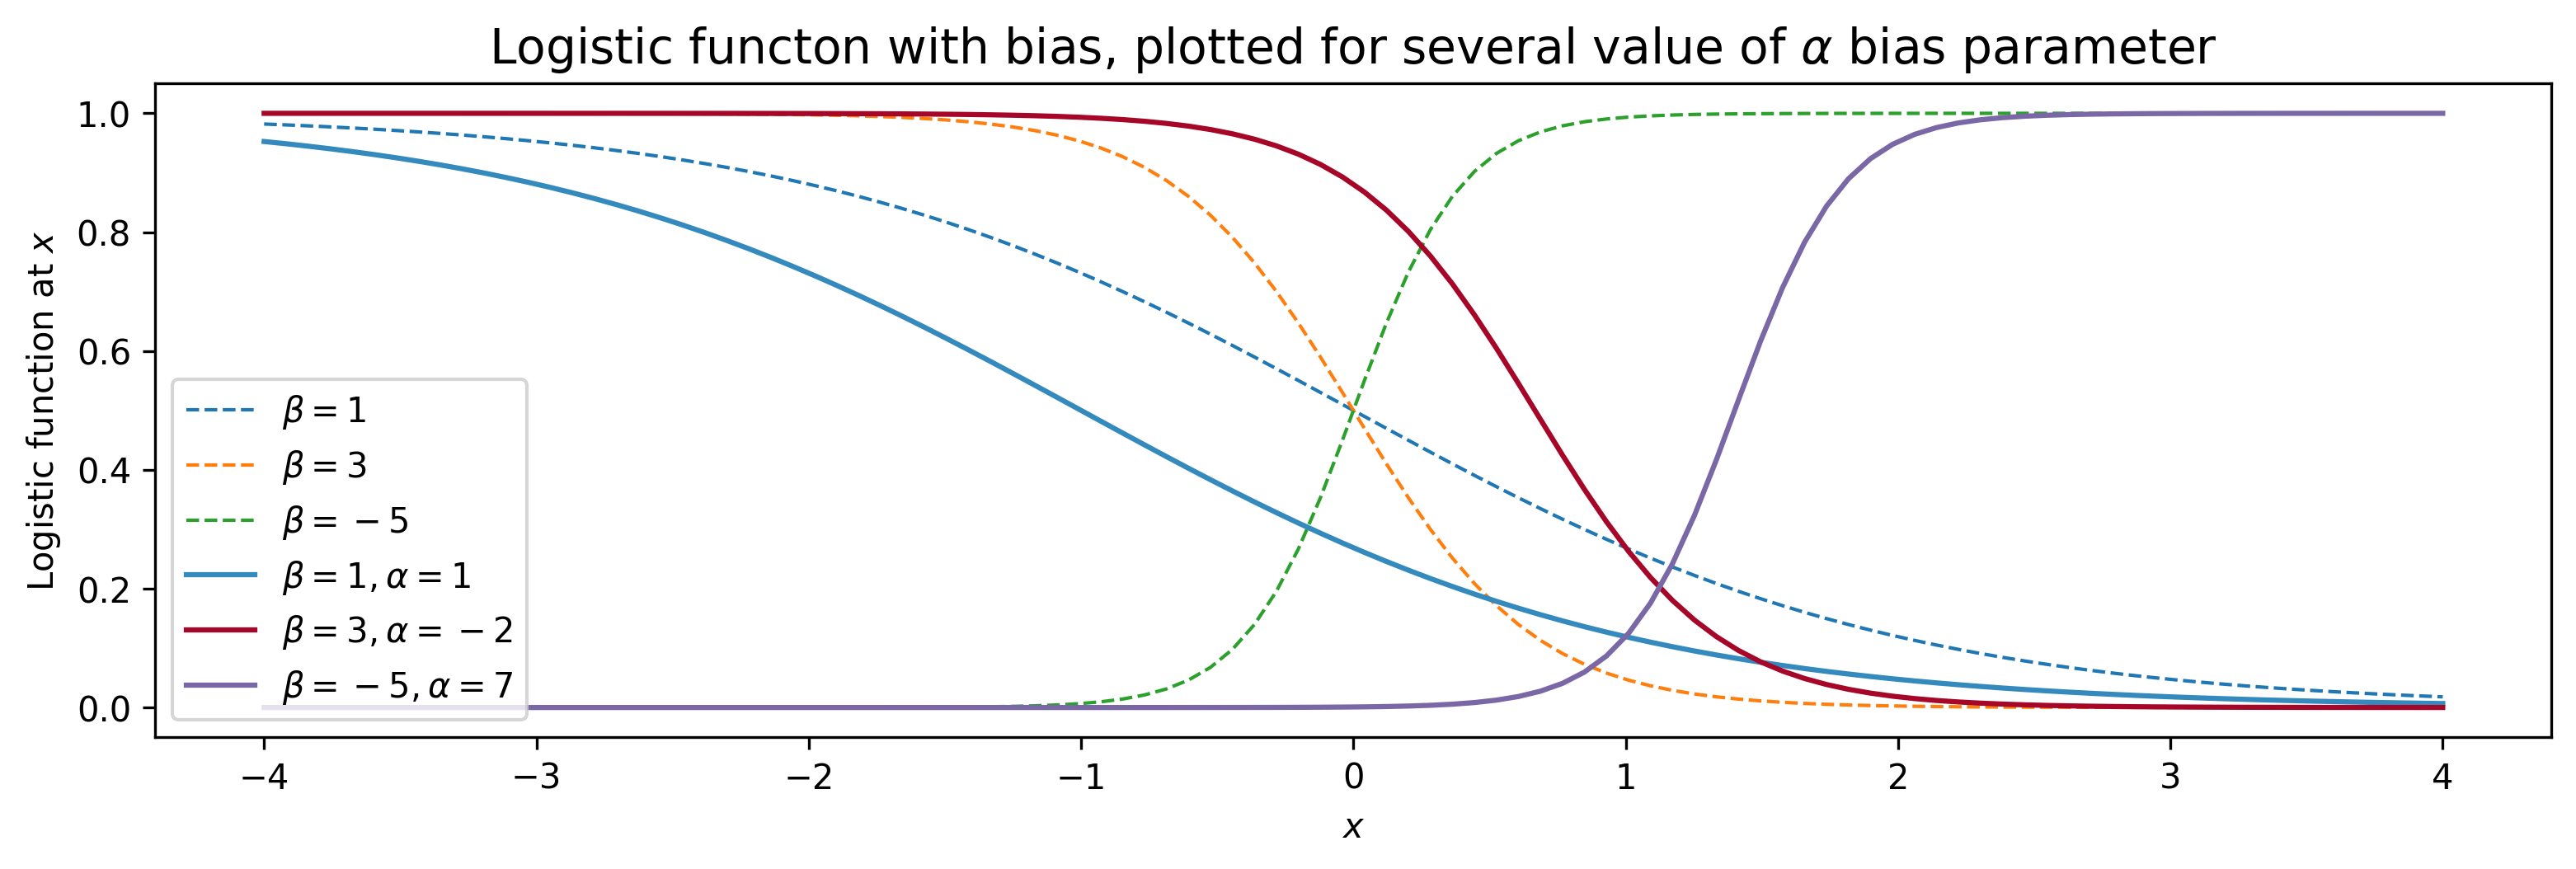

In [ ]:
x = np.linspace(-4, 4, 100)


plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")
plt.xlabel('$x$')
plt.ylabel('Logistic function at $x$')
plt.title("Logistic functon with bias, plotted for several value of $\\alpha$ bias parameter", fontsize=14)
plt.legend(loc="lower left");

###The Normal Distribution
A Normal random variable, denoted $X\sim N(\mu, 1/\tau)$, has a distribution with two parameters: the mean $\mu$ and the *precision* $\tau$. The variance $\sigma^2 = \tau^{-1}$. The smaller the $\tau$, the wider the distribution.

The probability density function of a $N(\mu, 1/\tau)$ random variable is 
$$f(x|\mu,\tau)=\sqrt{\frac{\tau}{2\pi}}\exp\left(-\frac{\tau}{2}(x-\mu)^2\right)$$

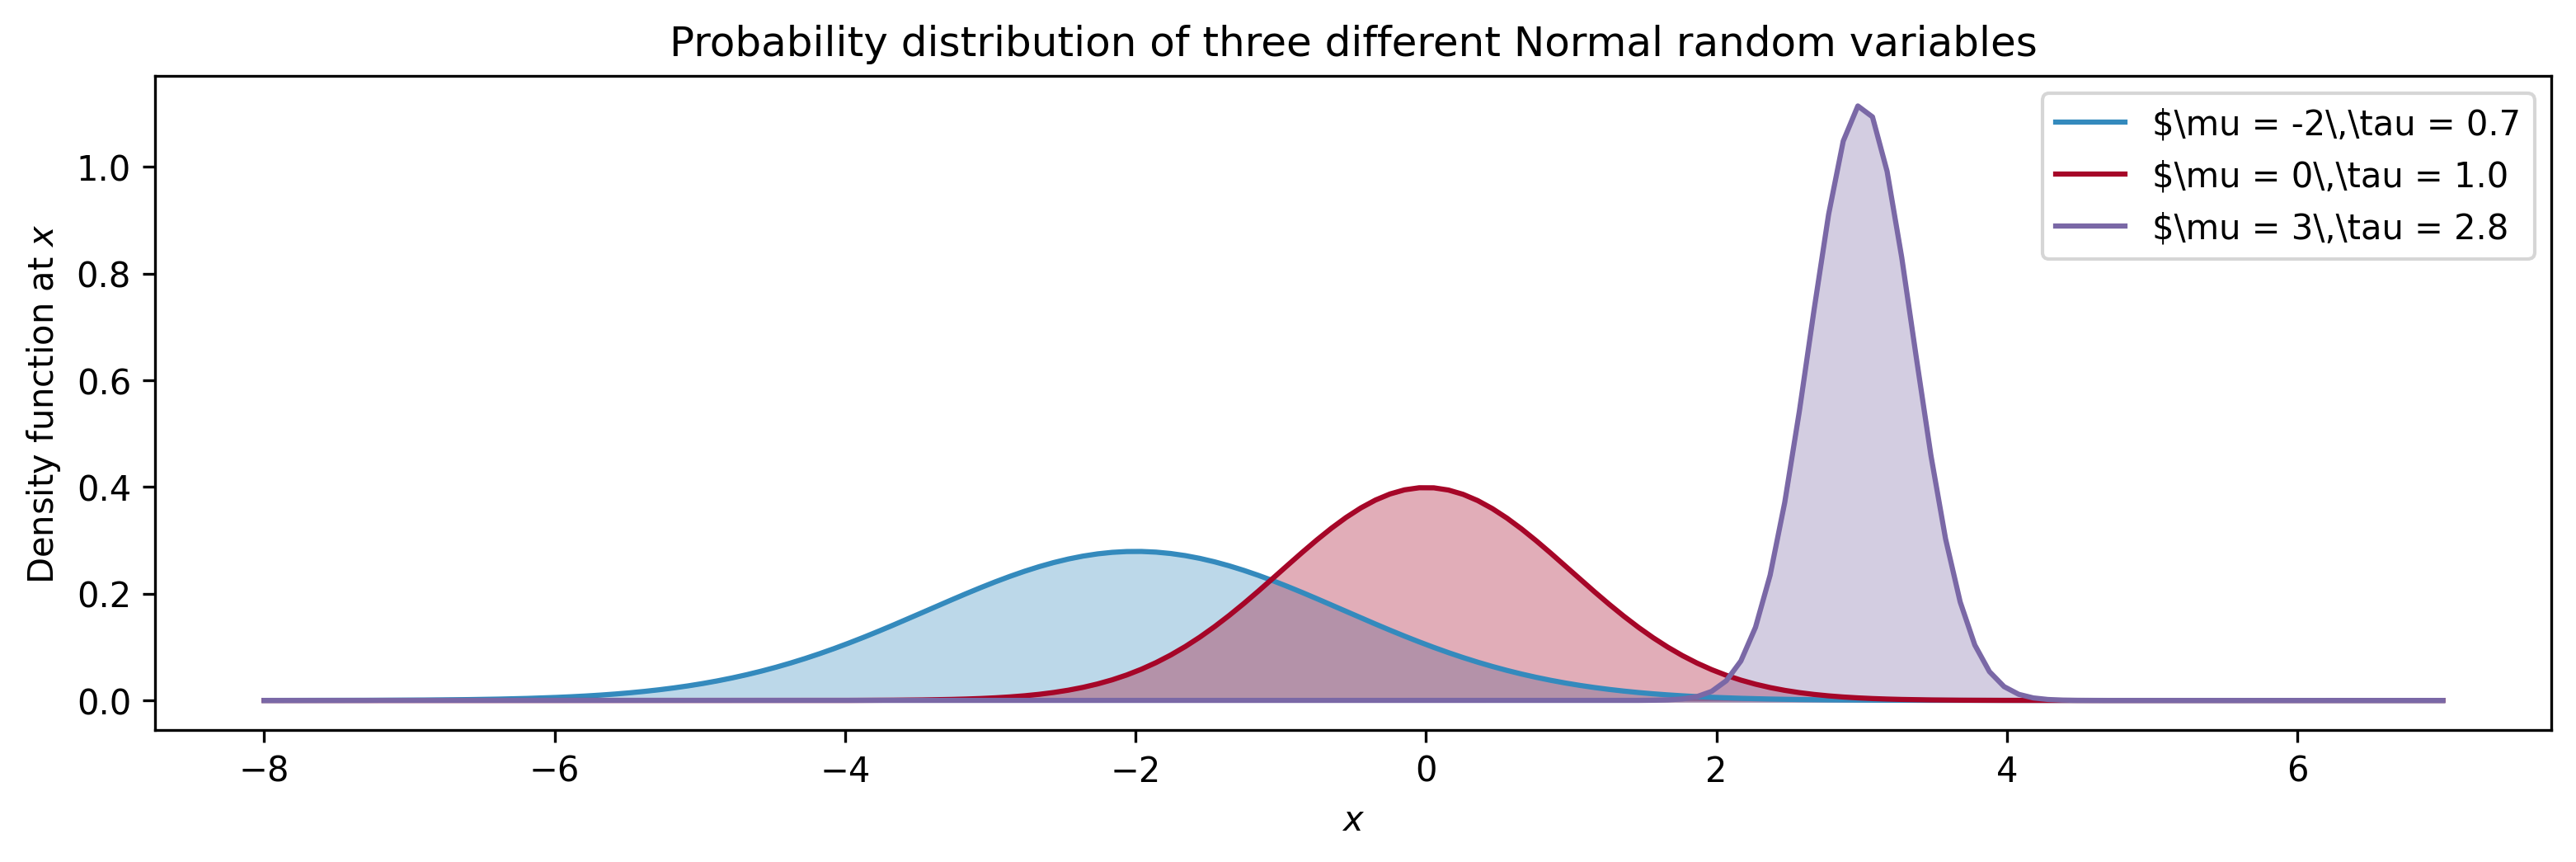

In [ ]:
nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./_tau),
             label='$\mu = {:d}\,\\tau = {:.1f}'.format(_mu, _tau),
             color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1./_tau), color=_color, alpha=.33)
plt.legend(loc='upper right')
plt.xlabel('$x$')
plt.ylabel('Density function at $x$')
plt.title('Probability distribution of three different Normal random variables');

A Normal random variable can take on any real number, but the variable is very likely to be relatively close to $\mu$. The expected value of a Normal is equal to its $\mu$.
$$E[X|\mu,\tau]=\mu$$
and its variance is equal to the inverse of $\tau$:
$$Var(X|\mu,\tau)=\frac{1}{\tau}$$

For the Challenger space craft:

In [ ]:
temperature = challenger_data[:, 1][:-1].astype(int)
D = challenger_data[:, 2][:-1].astype(int)

# Note the "value" here:
beta = pm.Normal('beta', 0, 0.001, value=0)
alpha = pm.Normal('alpha', 0, 0.001, value=0)

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

To connect the probabilities with the observed data, use a *Bernoulli* random variable. The model looks like:
$$\text{Defect Incident,}\, D_i\sim \text{Ber}(p(t_i)),\, i=1...N$$
where $p(t)$ is the logistic function and $t_i$ is the temperatures for the observations. `alpha` and `beta` are set to zeros because they make `p` equal to 1 or 0 if `alpha` and `beta` are very large. `pm.Bernoulli` does not like probabilities of exactly 0 or 1.

This will set `p` a reasonable starting value.

In [ ]:
p.value

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [ ]:
# Connect the probabilities in "p" with observations through a
# Bernoulli random variable
observed = pm.Bernoulli('bernoulli_obs', p, value=D, observed=True)

model = pm.Model([observed, beta, alpha])

map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

/usr/local/lib/python3.6/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 120000 of 120000 complete in 10.6 sec

The model is trained on the observed data; now sample values from the posterior:

In [ ]:
alpha_samples = mcmc.trace('alpha')[:, None] # best to make them 1D
beta_samples = mcmc.trace('beta')[:, None] 

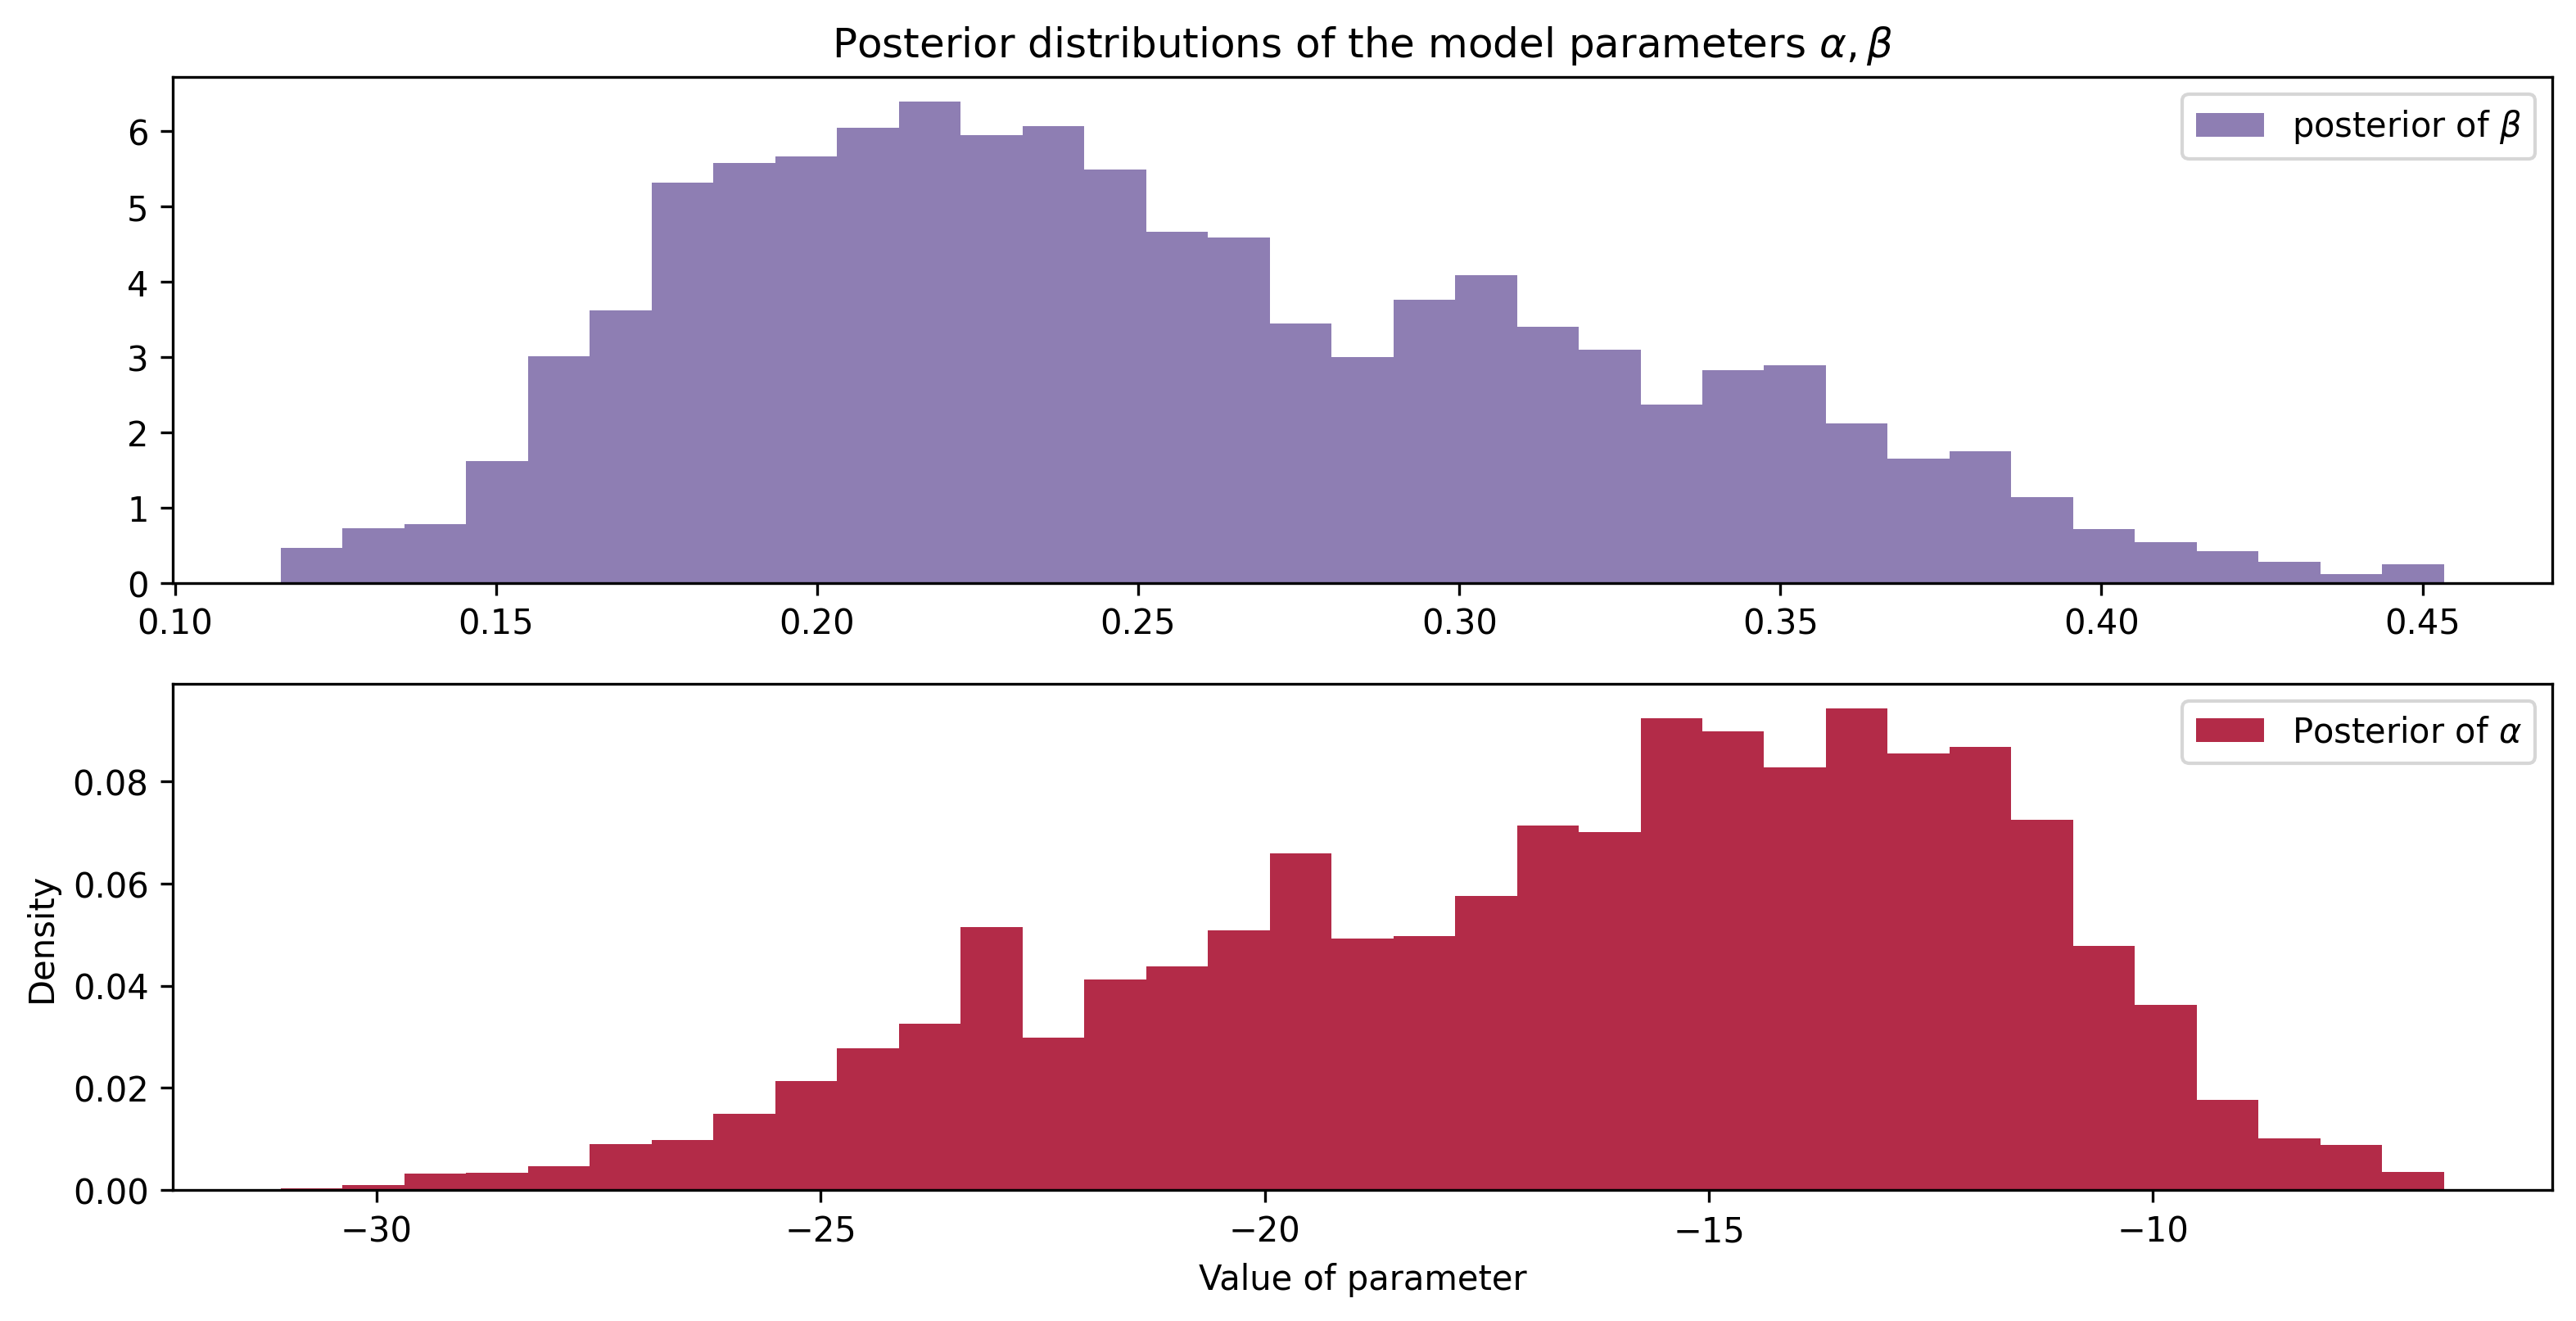

In [ ]:
figsize(12.5, 6)

#histogram of the samples
plt.subplot(211)
plt.title(r'Posterior distributions of the model parameters $\alpha, \beta$')
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r'posterior of $\beta$', color='#7A68A6', density=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r'Posterior of $\alpha$', color='#A60628', density=True)
plt.xlabel('Value of parameter')
plt.ylabel('Density')
plt.legend();

The spread of the data tells the uncertaintiy about the true parameters

The *expected probability* for a specific value of the temperature is the average over all samples from the posterior to get a likely value for $p(t_i)$:

In [ ]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

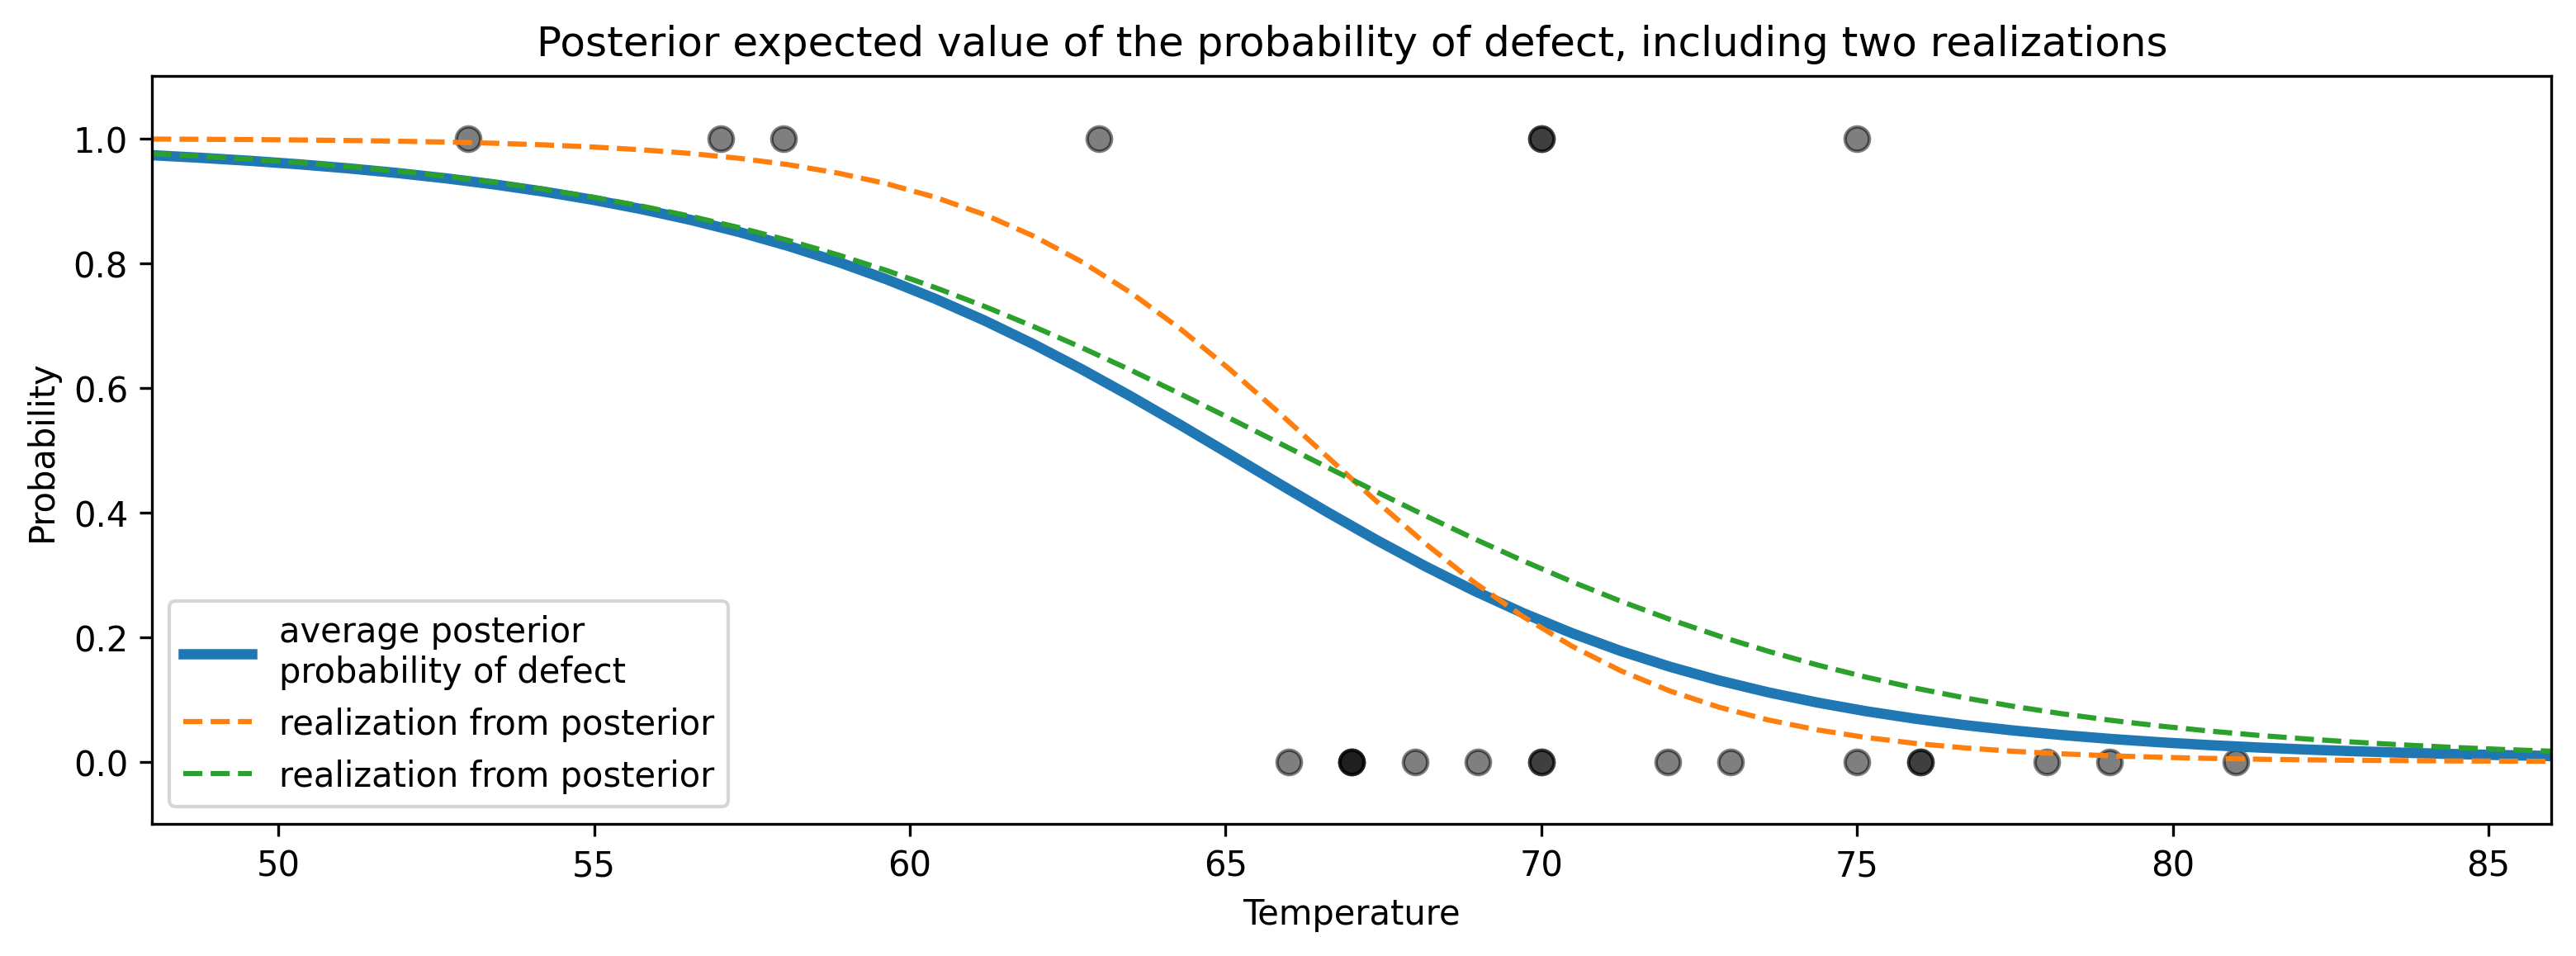

In [ ]:
figsize(12.5, 4)
plt.plot(t, mean_prob_t, lw=3, label='average posterior \nprobability of defect')
plt.plot(t, p_t[0, :], ls='--', label='realization from posterior')
plt.plot(t, p_t[-2,:], ls='--', label='realization from posterior')
plt.scatter(temperature, D, color='k', s=50, alpha=0.5)
plt.title('Posterior expected value of the probability of defect, including two realizations')
plt.legend(loc='lower left')
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel('Probability')
plt.xlabel('Temperature');

For what temperatures are most uncertain about the defect probability?

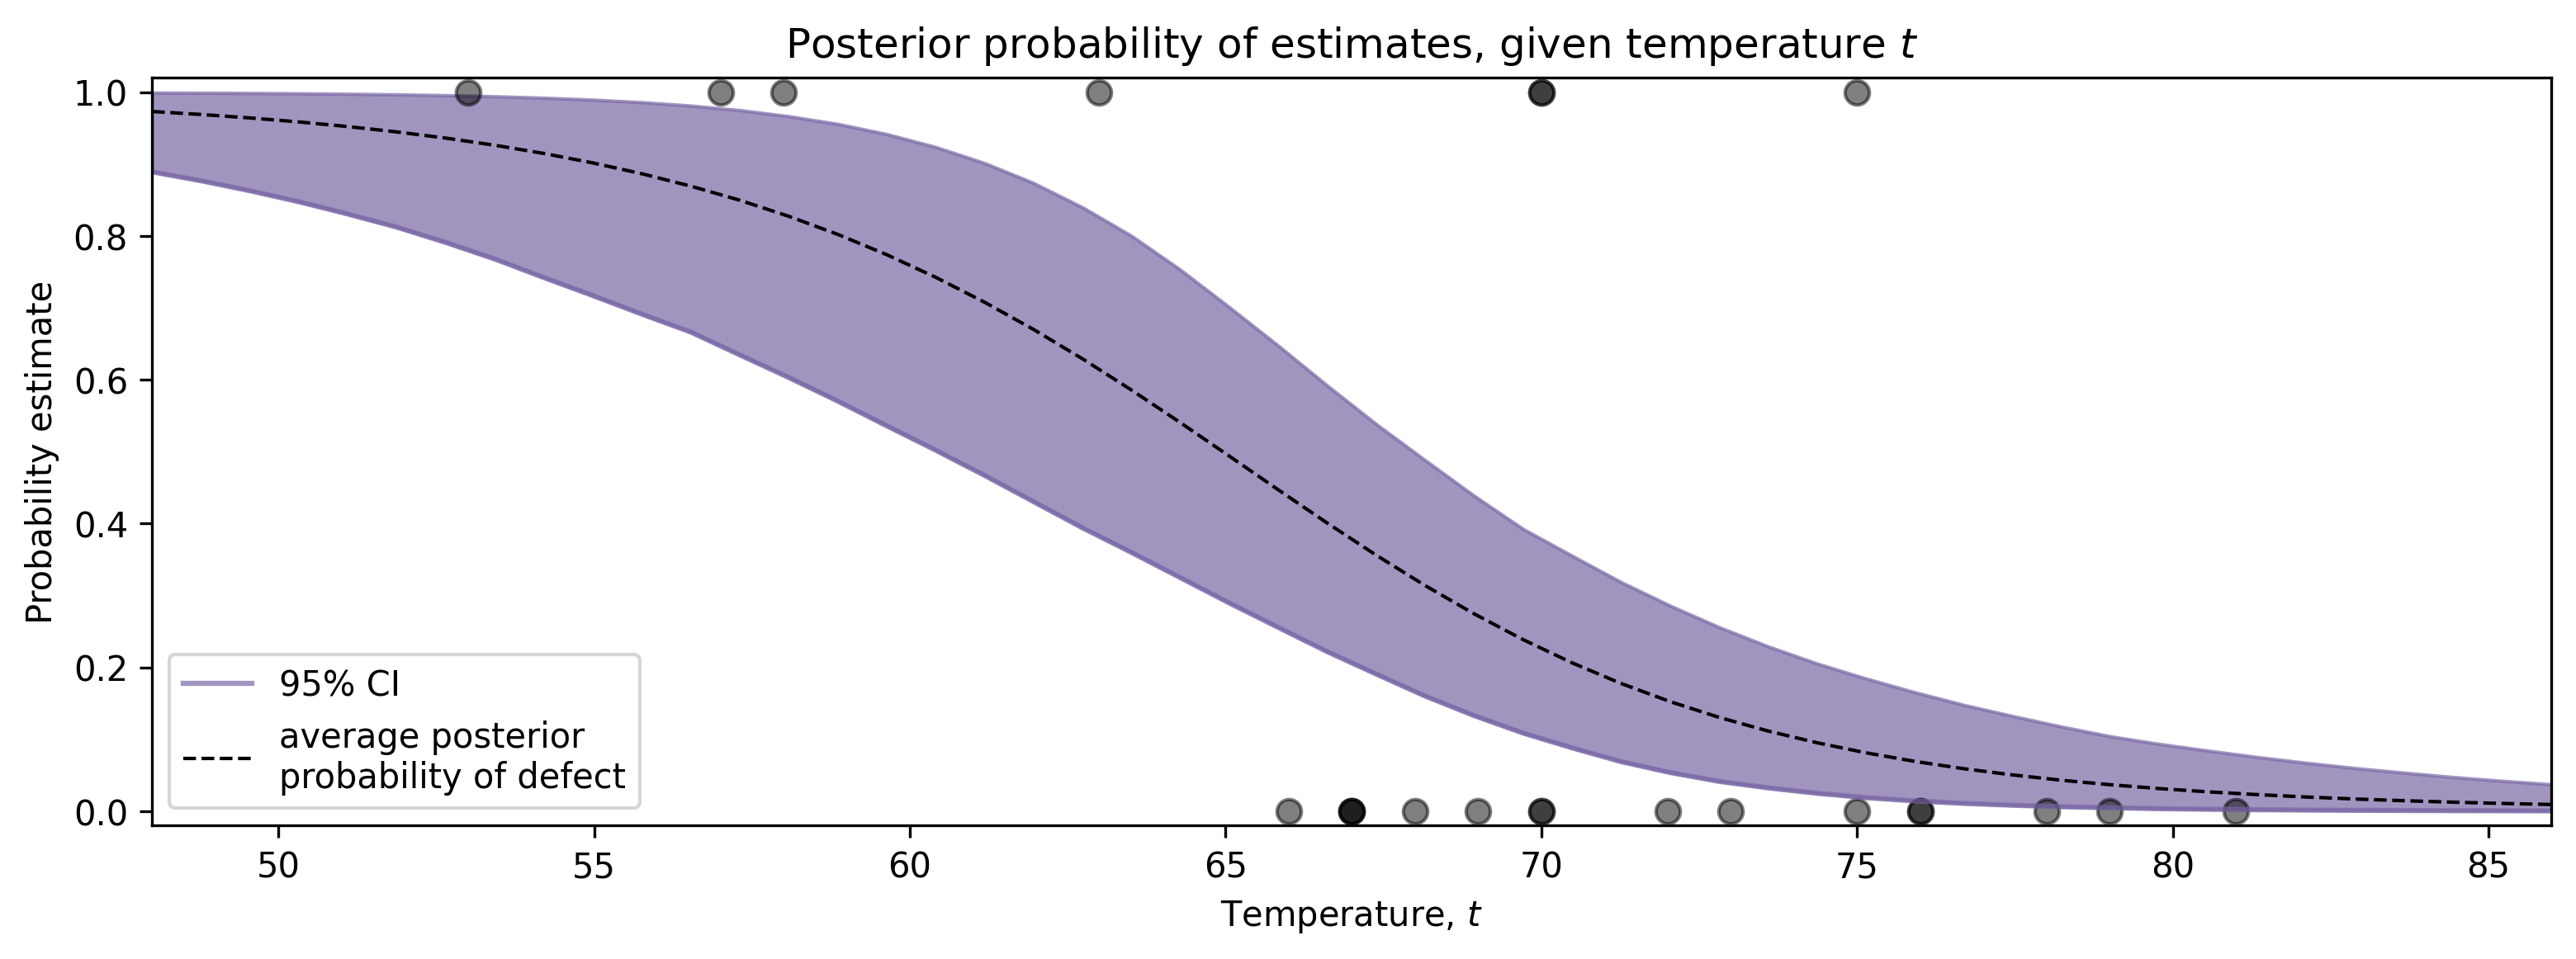

In [ ]:
from scipy.stats.mstats import  mquantiles

# vectorized bottom and top 2.5% quantiles for "credible interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7, color='#7A68A6')
plt.plot(t[:,0], qs[0], label='95% CI', color='#7A68A6', alpha=0.7)
plt.plot(t, mean_prob_t, lw=1, ls='--', color='k',
         label='average posterior \nprobability of defect')
plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower left')
plt.scatter(temperature, D, color='k', s=50, alpha=0.5)
plt.xlabel('Temperature, $t$')
plt.ylabel('Probability estimate')
plt.title('Posterior probability of estimates, given temperature $t$');

The **95% credible interval**, or 95% CI, represents the interval, for each temperature, that contains 95% of the distribution. This is different from the frequentist *confidence interval*, which does not have the same interpretation.

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit:

In [ ]:
prob_31 = logistic(31, beta_samples, alpha_samples)

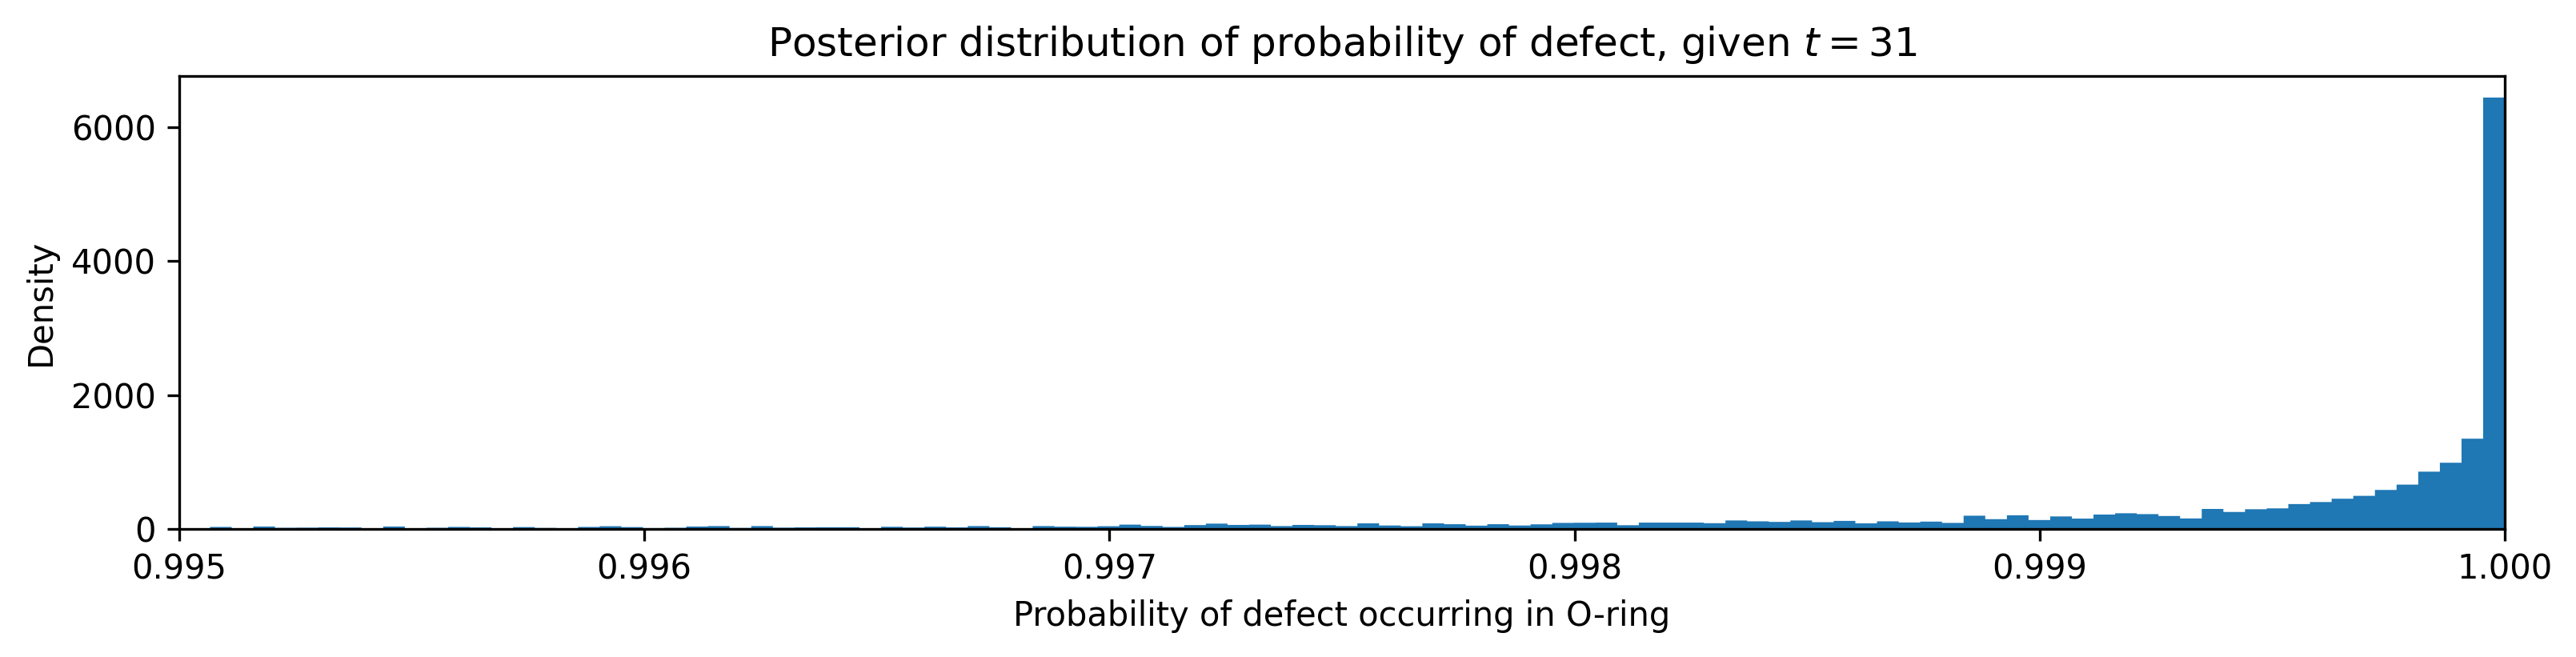

In [ ]:
figsize(12.5, 2.5)
plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, density=True, histtype='stepfilled')
plt.title('Posterior distribution of probability of defect, given $t = 31$')
plt.ylabel('Density')
plt.xlabel('Probability of defect occurring in O-ring');

##Appropriate Models

Meaure the model's **goodness of fit**

1. Simulate an artificial dataset;
2. Sample values from the priors (that is, sample values from a model that was not fitted to the data);

Create a new `Stochastic`-type variable that is exactly the same as the variable that stored the observations but minus the observations themselves.

In [ ]:
observed = pm.Bernoulli('bernoulli_obs', p, value=D, observed=True)

initialize the following variable to create plausible datasets:

In [ ]:
simulated_data = pm.Bernoulli('simulation_data', p)

simulated = pm.Bernoulli('bernoulli_sim', p)
N = 10000

mcmc = pm.MCMC([simulated, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.7 sec

In [ ]:
simulations = mcmc.trace('bernoulli_sim')[:].astype(int)
print('Shape of simulations array:', simulations.shape)

Shape of simulations array: (10000, 23)


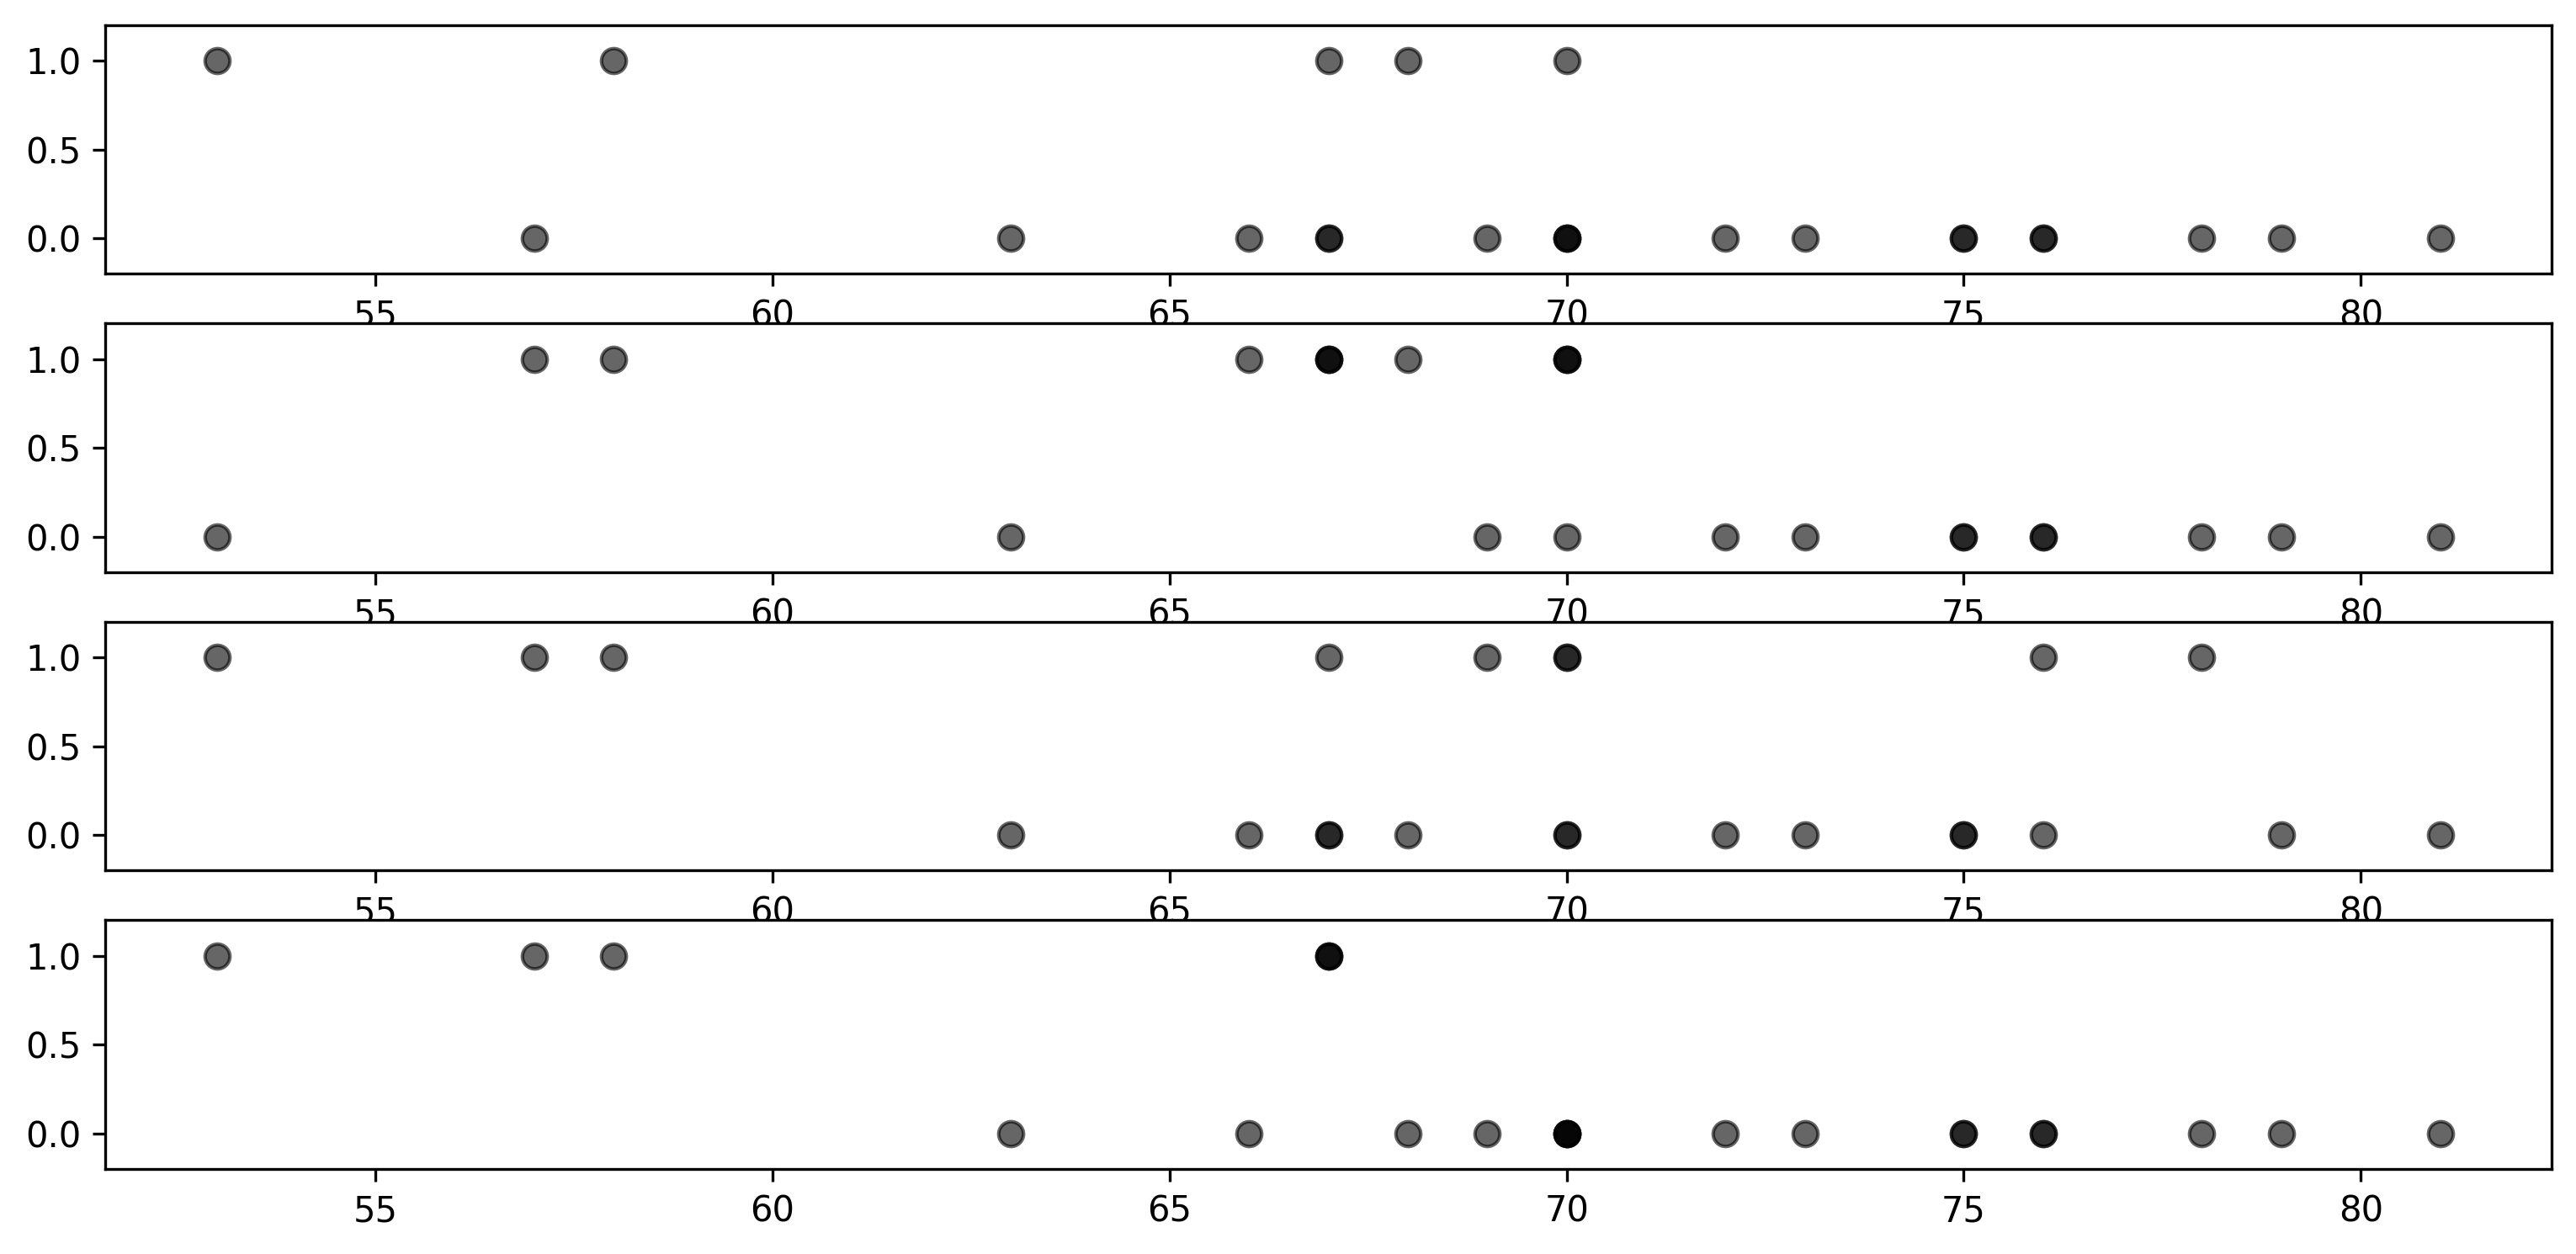

In [ ]:
figsize(12.5, 6)
plt.title('Simulated datasets using posterior parameters')
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    ax.set_ylim(-0.2, 1.2)
    plt.scatter(temperature, simulations[1000*i, :], color='k',
                s=50, alpha=0.6);

The **Bayesian p-values** are a statistical summary of the model, and analogous to frequentist p-values. Bayesian p-values are also subjective, as the proper cutoff between what is deemed *good* and *bad* is arbitrary.

###Separation Plots
**Separation plots** allow the user to graphically compare a suite of models against each other.

For each model, calculate the proportion of times the posterior simulation proposed a value of 1 for a particular temperature.

In [ ]:
posterior_probability = simulations.mean(axis=0)
print('Obs. | Array of Simulated Defects |  Posterior Probability of Defect | Realized Defect')
for i in range(len(D)):
    print('{:s}   | {:s}|      {:.2f}       | {:d}'.format(
        str(i).zfill(2), str(simulations[:10, i])[:-1]+'...]'.ljust(12),
        posterior_probability[i], D[i]
    ))

Obs. | Array of Simulated Defects |  Posterior Probability of Defect | Realized Defect
00   | [0 0 0 0 1 0 0 1 0 1...]        |      0.51       | 0
01   | [1 0 1 0 0 1 0 0 0 1...]        |      0.30       | 1
02   | [0 0 0 0 1 0 1 0 0 0...]        |      0.36       | 0
03   | [1 0 0 1 0 1 0 0 1 1...]        |      0.41       | 0
04   | [0 1 0 0 1 1 1 0 1 0...]        |      0.46       | 0
05   | [0 0 0 1 0 0 0 0 0 0...]        |      0.22       | 0
06   | [0 1 0 0 0 0 0 0 0 0...]        |      0.18       | 0
07   | [0 1 0 0 0 0 0 0 0 0...]        |      0.31       | 0
08   | [0 1 1 1 1 1 1 1 1 1...]        |      0.87       | 1
09   | [0 0 1 1 1 1 0 1 1 1...]        |      0.66       | 1
10   | [0 0 0 0 1 1 0 0 1 1...]        |      0.31       | 1
11   | [0 0 0 1 0 0 0 0 0 0...]        |      0.08       | 0
12   | [1 0 0 0 1 0 0 0 0 1...]        |      0.46       | 0
13   | [1 1 1 1 1 1 1 1 1 0...]        |      0.93       | 1
14   | [0 1 1 0 0 1 0 0 0 1...]        |      0.46       | 

Next, sort each column by the posterior probabilities.

In [ ]:
ix = np.argsort(posterior_probability)
print('Posterior Probability of Defect | Realized Defect')
for i in range(len(D)):
    print('            {:.2f}                |  {:d}'.format(
        posterior_probability[ix[i]], D[ix[i]]
    ))

Posterior Probability of Defect | Realized Defect
            0.04                |  0
            0.06                |  0
            0.08                |  0
            0.11                |  0
            0.11                |  0
            0.13                |  0
            0.13                |  1
            0.18                |  0
            0.22                |  0
            0.30                |  1
            0.31                |  1
            0.31                |  0
            0.31                |  0
            0.36                |  0
            0.41                |  0
            0.46                |  0
            0.46                |  0
            0.46                |  0
            0.51                |  0
            0.66                |  1
            0.84                |  1
            0.87                |  1
            0.93                |  1


In [ ]:
def separation_plot( p, y, **kwargs ):
    """
    This function creates a separation plot for logistic and probit classification. 
    See http://mdwardlab.com/sites/default/files/GreenhillWardSacks.pdf
    
    p: The proportions/probabilities, can be a nxM matrix which represents M models.
    y: the 0-1 response variables.
    
    """    
    assert p.shape[0] == y.shape[0], "p.shape[0] != y.shape[0]"
    n = p.shape[0]

    try:
        M = p.shape[1]
    except:
        p = p.reshape( n, 1 )
        M = p.shape[1]

    colors_bmh = np.array( ["#eeeeee", "#348ABD"] )


    fig = plt.figure( )
    
    for i in range(M):
        ax = fig.add_subplot(M, 1, i+1)
        ix = np.argsort( p[:,i] )
        #plot the different bars
        bars = ax.bar( np.arange(n), np.ones(n), width=1.,
                color = colors_bmh[ y[ix].astype(int) ], 
                edgecolor = 'none')
        ax.plot( np.arange(n+1), np.append(p[ix,i], p[ix,i][-1]), "k",
                 linewidth = 1.,drawstyle="steps-post" )
        #create expected value bar.
        ax.vlines( [(1-p[ix,i]).sum()], [0], [1] )
        plt.xlim( 0, n)
    plt.ylabel('Predicted')
    plt.xlabel('Events, sorted by the model\'s probability of occurring')
    plt.tight_layout()
    
    return

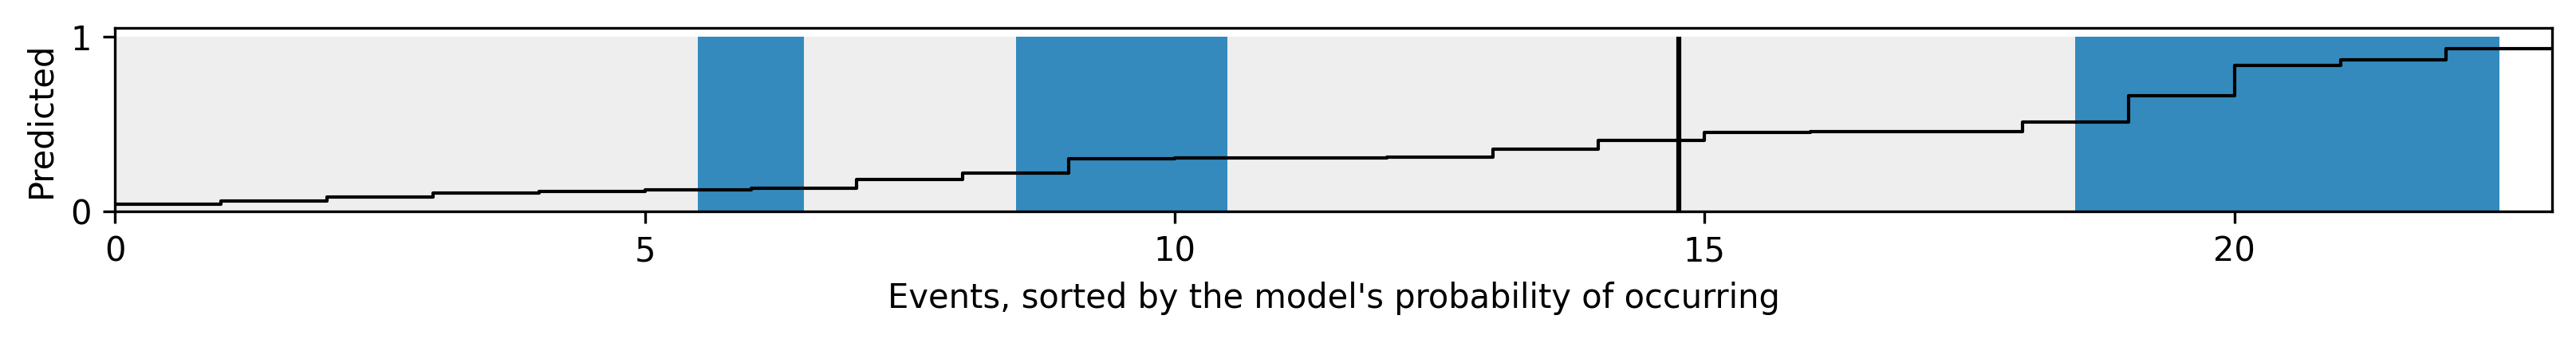

In [ ]:
figsize(11, 1.5)
separation_plot(posterior_probability, D)

The snaking line is the sorted posterior probabilities, blue bars denote realized defects, and empty space dentoe non-defects.

As the probability rises, more and more defects occur. The plot suggests that as the posterior probability is large (line close to 1), then more defects are realized. Ideally, all the blue bars *should* be close to the right-hand side, and deviations from this reflect missed predictions.

The black vertical line is lcoated at the expected number of defects, given this model. This allows users to see how the total number of events predicted by the model compares to the actual number of events in the data.

The following plots are compared the existing model with the three others:
1. The perfect-prediction model, which sets the posterior probability to be equal to 1 if a defect did occur and 0 if a defect did not occur
2. A completely random model, which predicts random probabilities regardless of the temperature
3. and A constant model, where $P(D=1|t)=c,\,\forall t$. The best choice for $c$ is the observed frequency of defects - 7/23.

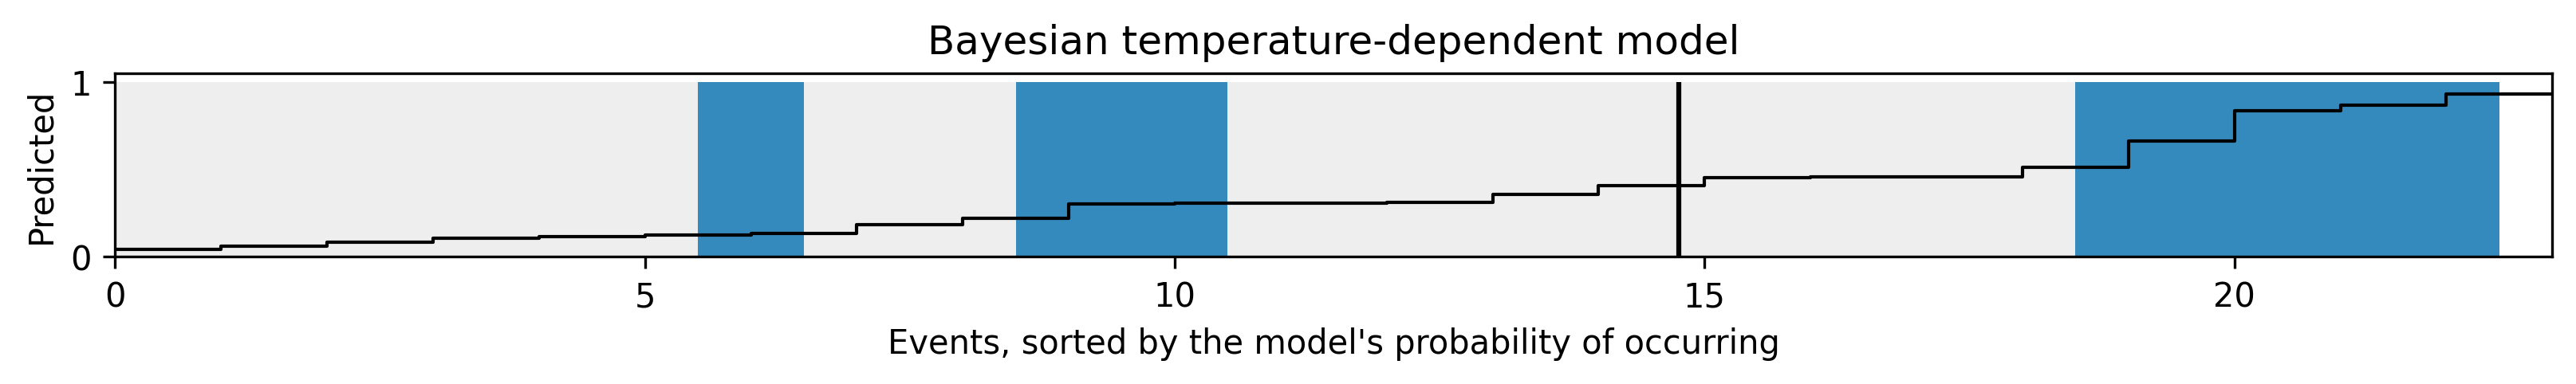

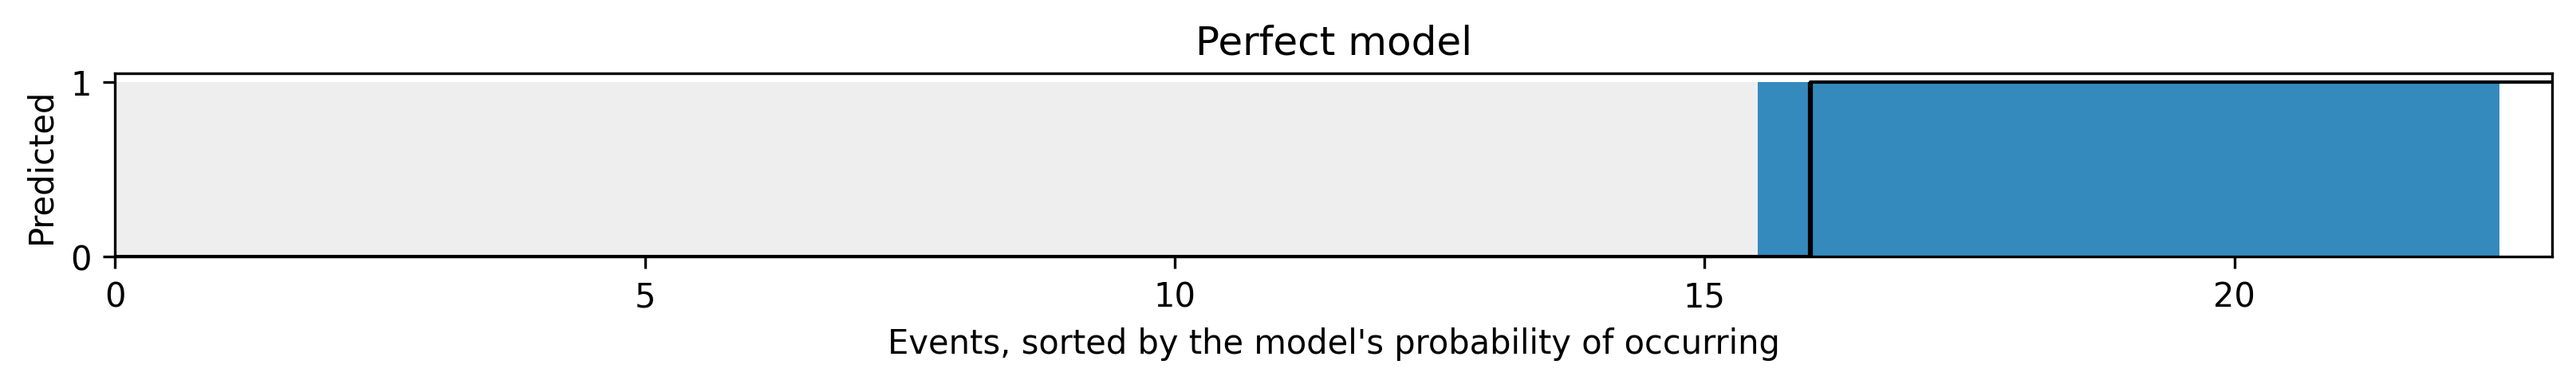

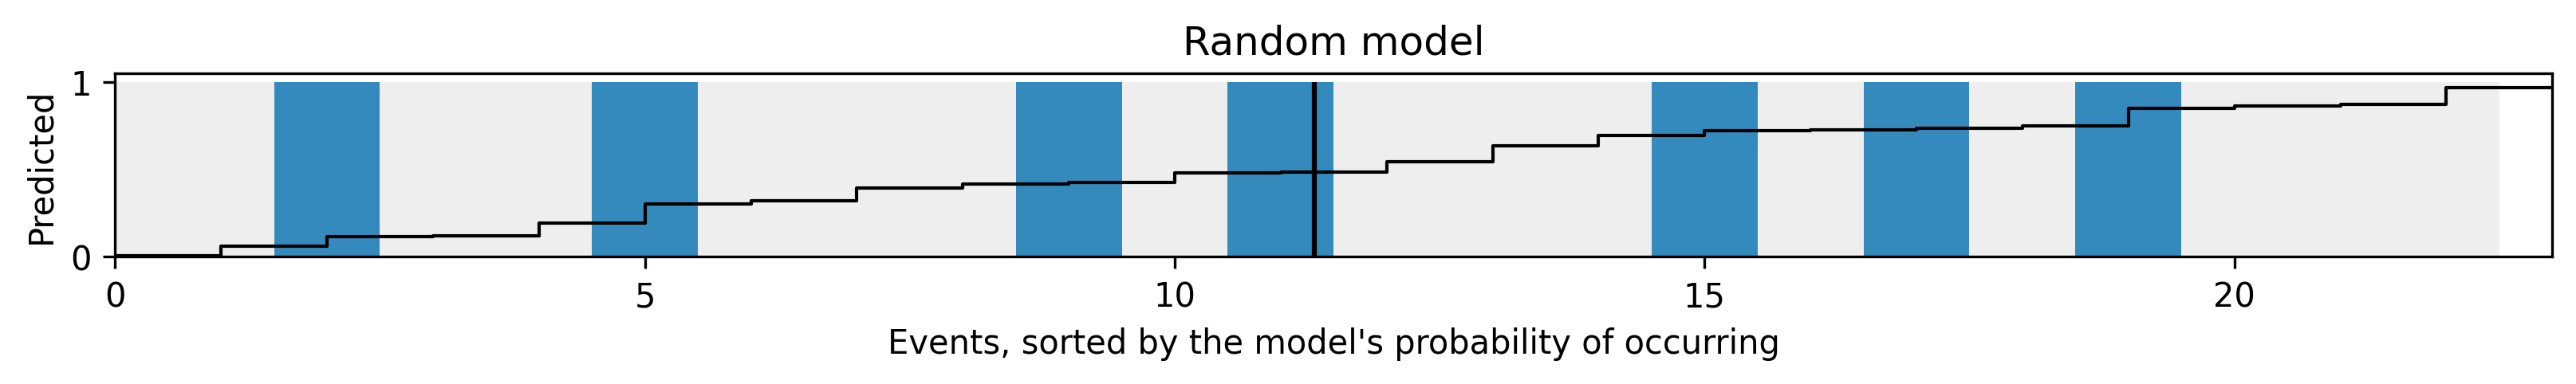

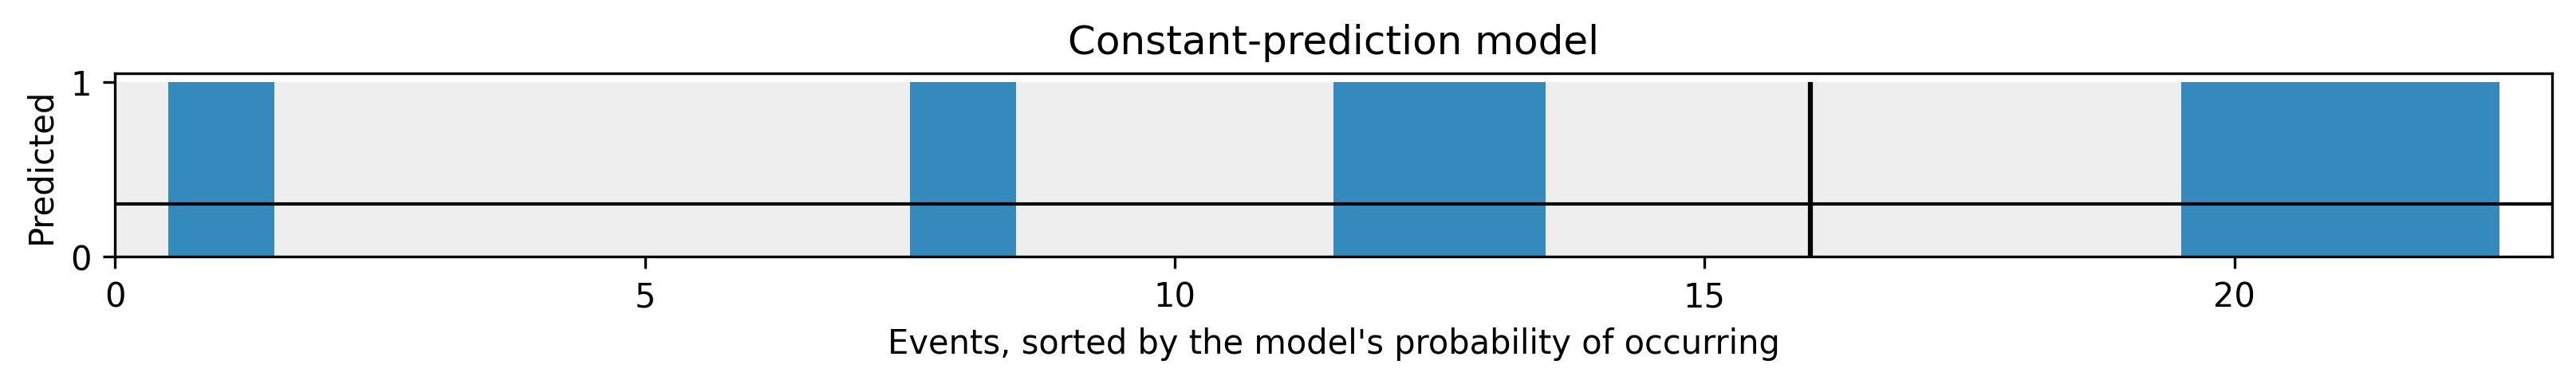

In [ ]:
# existing temperature-dependent model
separation_plot(posterior_probability, D)
plt.title('Bayesian temperature-dependent model')

# perfect model
# (the probability of defect is equal to if a defect occurred or not)
p = D
separation_plot(p, D)
plt.title('Perfect model')

# random predictions
p = np.random.rand(23)
separation_plot(p, D)
plt.title('Random model')

# constant model
constant_prob = 7./23 * np.ones(23)
separation_plot(constant_prob, D)
plt.title('Constant-prediction model');

##PyMC3

In PyMC3, all variables are usually handled in the `Model` object

In [1]:
import pymc3 as pm

with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', 1.0)
    data_generator = pm.Poisson('data_generator', parameter)

Any variable created within a given `Model`'s context will be automatically assigned to that model.

In [2]:
with model:
    data_plus_one = data_generator + 1

Once the variables are defined, they can be examined outside of the model context.

In [3]:
parameter.tag.test_value

array(0.69314718)

Each variable assigned to a model will be defined with its own name, the first string parameter. To create a different model object with the same name, need to run the first block of code again:

In [4]:
with pm.Model() as model:
    theta = pm.Exponential('theta', 2.0)
    data_generator = pm.Poisson('data_generator', theta)

###PyMC3 Variables
All PyMC3 variables have an initial values (i.e., test value)

In [5]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


The `test_value` is used as the starting point for sampling. This can be changed at variable creation by specifying `testval` parameter

In [6]:
with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', 1.0,
                               testval=0.5)
print('parameter.tag.test_value =', parameter.tag.test_value)

parameter.tag.test_value = 0.5


A **stochastic**, or random, variable requires a `name` argument and additional parameters that are class specific:

In [ ]:
some_var = pm.DiscreteUniform('discrete_uni_var', 0, 4)

For multivariable problems, use the `shape` keyword in the call to a stochastic variable creates multivariate array of (independent) stochastic variables:

In [ ]:
N = 100
betas = pm.Uniform('betas', 0, 1, shape=N)

A **deterministic** variable can be created using the `Deterministic` class

In [ ]:
deterministic_var = pm.Deterministic('deterministic_var', some_func_of_var)

Or using *elementary operations:

In [7]:
with pm.Model() as model:
    lambda_1 = pm.Exponential('lambda_1', 1.0)
    lambda_2 = pm.Exponential('lambda_2', 1.0)
    tau = pm.DiscreteUniform('tau', lower=0, upper=10)

new_deterministic_var = lambda_1 + lambda_2

For example, 
$$\lambda=\begin{cases}
\lambda_1 & \text{if }t<\tau\\
\lambda_2 & \text{if }t\geq\tau
\end{cases}$$
in PyMC3 is

In [9]:
n_data_points = 10
idx = np.arange(n_data_points)
with pm.Model() as model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

The majority of the heavy lifting done by PyMC3 is taken care of with the `theano` package. `theano` builds up a "computational graph" that tracks the math operations. The computation takes place once the `eval()` method is called.

For example,

In [10]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])

    assignment = pm.Categorical('assignment', p)

`theano`'s `stack()` function combines two separate variables into a vector with 2 elements. The `pm.Categorical` function needs only one argument so passing one `theano` variable causes no error.

###Including observations in PyMC3 Model

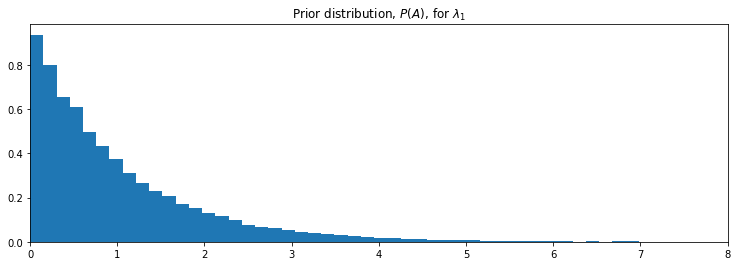

In [13]:
samples = lambda_1.random(size=20000)

figsize(12.5, 4)
plt.hist(samples, bins=70, density=True, histtype='stepfilled')
plt.title('Prior distribution, $P(A)$, for $\lambda_1$')
plt.xlim(0,8);

The keyword `observed` is used to fix the variable's current value to be the given data, typically a NumPy `array` or pandas `DataFrame`:

In [14]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson('fxd', 1, observed=data)
print('value: ', fixed_variable.tag.test_value)

value:  [10  5]


This is the way to include data into models:

In [16]:
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson('obs', 5, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


###Modeling approaches
Specify when the user's behavior switches by sampling from DiscreteUniform(0, 80):

In [17]:
tau = np.random.randint(0, 80)
print(tau)

27


Draw $\lambda_1$ and $\lambda_2$ from an $Exp(\alpha)$ distribution:

In [18]:
alpha = 1./20
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

5.950848336942539 18.326554049082024


For days before $\tau$, represent the user's received SMS count by sampling from $Poi(\lambda_1)$; otherwise $Poi(\lambda_2)$.

In [19]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau),
             stats.poisson.rvs(mu=lambda_2, size=80-tau)]

Plot the artificial dataset:

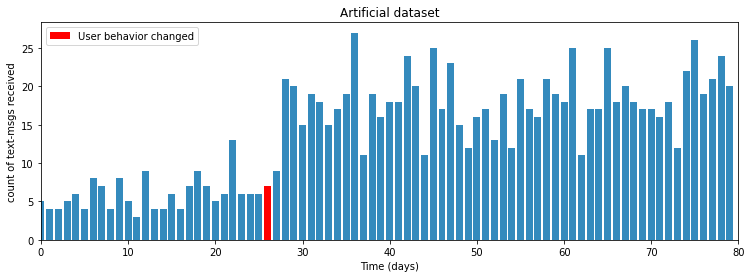

In [20]:
plt.bar(np.arange(80), data, color='#348ABD')
plt.bar(tau-1, data[tau-1], color='r', label='User behavior changed')
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

To create a few more datasets:

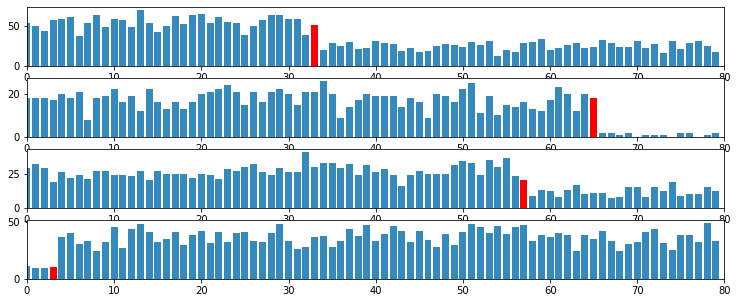

In [21]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

figsize(12.5, 5)
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

Examples:

In [22]:
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

In [23]:
# set constants
p_true = 0.05
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences)
print(np.sum(occurrences))

[0 0 0 ... 0 0 0]
90


In [24]:
# Occurrences.mean() is equal to n/N
print('What is the observed frequency in Group A? {:.4f}'.format(np.mean(occurrences)))
print('Does this equal the true frequency? {}'.format(np.mean(occurrences)==p_true))

What is the observed frequency in Group A? 0.0600
Does this equal the true frequency? False


In [25]:
# include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli('obs', p, observed=occurrences)

    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Sequential sampling (2 chains in 1 job)
Metropolis: [p]
100%|██████████| 18500/18500 [00:03<00:00, 5546.36it/s]
The number of effective samples is smaller than 25% for some parameters.


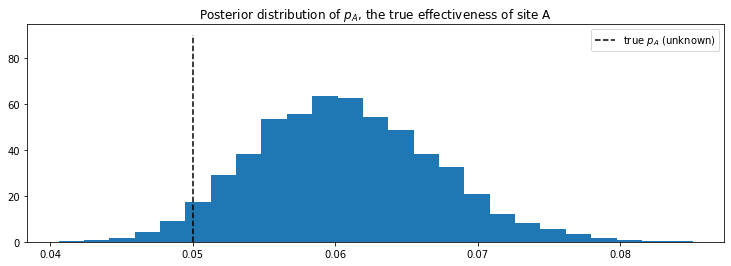

In [26]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace['p'], bins=25, histtype='stepfilled', density=True)
plt.legend();

In [27]:
# these two quantities are unknown
true_p_A = 0.05
true_p_B = 0.04

# notice the unequal sample sizes
N_A = 1500
N_B = 750

# generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print('Obs from Site A: ', observations_A[:30], '...')
print('Obs from Site B: ', observations_B[:30], '...')

Obs from Site A:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [28]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.048666666666666664
0.02666666666666667


In [29]:
# set up PyMC3 model. Assume Uniform priors for p_A and p_B
with pm.Model() as model:
    p_A = pm.Uniform('p_A', 0, 1)
    p_B = pm.Uniform('p_B', 0, 1)

    # define the deterministic delta function. This is unknown of interest
    delta = pm.Deterministic('delta', p_A - p_B)

    # set of observations
    obs_A = pm.Bernoulli('obs_A', p_A, observed=observations_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed=observations_B)

    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
100%|██████████| 20500/20500 [00:07<00:00, 2690.80it/s]
The number of effective samples is smaller than 25% for some parameters.


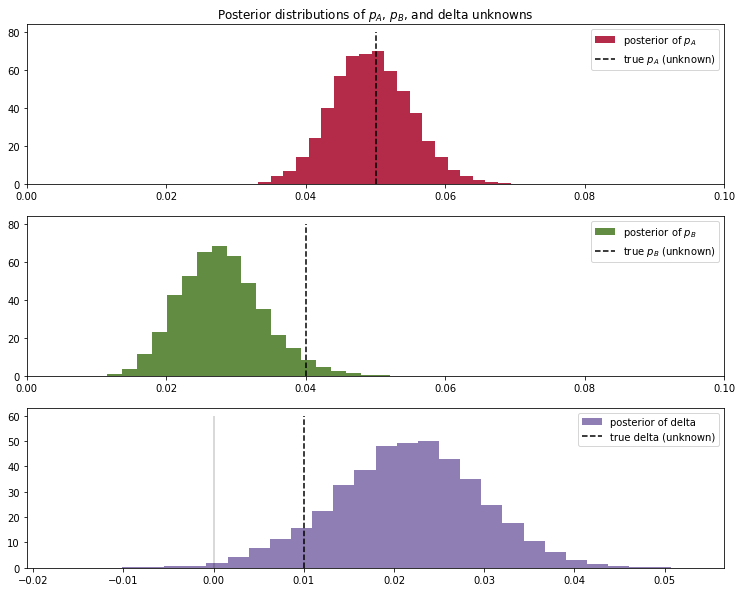

In [31]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

figsize(12.5, 10)

# histograms of posteriors
ax = plt.subplot(311)
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label='posterior of $p_A$', color='#A60628', density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)
plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [32]:
# count the number of samples less than 0, i.e., the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: {:.3f}".format(np.mean(delta_samples < 0)))

print("Probability site A is BETTER than site B: {:.3f}".format(np.mean(delta_samples > 0)))

Probability site A is WORSE than site B: 0.006
Probability site A is BETTER than site B: 0.994


For the cheating example,

In [33]:
N = 100
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)

with model:
    true_answers = pm.Bernoulli('truths', p, shape=N,
                                testval=np.random.binomial(1, 0.5, N))

Thinking of the above data-generation model, assign Bernoulli random variables to the 100 students: 1 implies they cheated and 0 implies they did not.

In [34]:
with model:
    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape=N,
                                    testval=np.random.binomial(1, 0.5, N))
print(first_coin_flips.tag.test_value)

[1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0
 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1]


In [35]:
with model:
    second_coin_flips = pm.Bernoulli('second_flips', 0.5, shape=N,
                                     testval=np.random.binomial(1, 0.5, N))

In [36]:
with model:
    val = first_coin_flips * true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic('observed_proportion', tt.sum(val)/float(N))

observed_proportion.tag.test_value

array(0.51999998)

In [37]:
# assume to receive 35 "Yes" responses
X = 35
with model:
    observations = pm.Binomial('obs', N, observed_proportion, observed=X)

    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
100%|██████████| 40500/40500 [14:46<00:00, 45.69it/s]
The number of effective samples is smaller than 10% for some parameters.


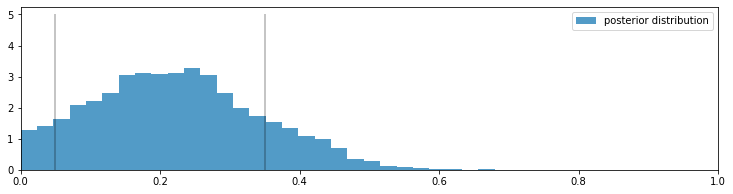

In [38]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

In [39]:
# Alternative PyMC3 model
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)
    p_skewed = pm.Deterministic('p_skewed', 0.5*p + 0.25)

    yes_responses = pm.Binomial('number_cheaters', 100, p_skewed, observed=X)

    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    burned_trace = trace[2500:]

Sequential sampling (2 chains in 1 job)
Metropolis: [freq_cheating]
100%|██████████| 25500/25500 [00:03<00:00, 6848.29it/s]
The number of effective samples is smaller than 25% for some parameters.


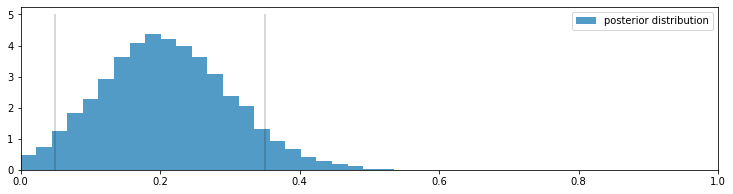

In [40]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

##Tensorflow Probability (not done)
In Tensorflow 2.0, eager execution is enabled by default

In [2]:
import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9] 

TFColor = _TFColor()

In [ ]:
def session_options(enable_gpu_ran_resizing=True, enable_xla=True):
    '''
    Allowing the notebook to make sure of GPUs if availble.
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes Tensorflow computations.
    '''
    config = 